In [1]:
import numpy as np
from soursop import sstrajectory, ssprotein
import mdtraj as md
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import sem
import seaborn as sns

In [2]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'arial',
        'weight' : 'normal'}

matplotlib.rc('font', **font)


# for rasterized=True
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
def read_psw(psw_file):
    psw = np.loadtxt(psw_file, skiprows=1, usecols=(1,2,3,4,5,6,7,8,9,10,11))
    return np.sum(psw, axis=1, dtype=int)

def get_fixed_idr_residues(psw_data):
    idr_psw = psw_data[:-97]

    start = np.where(idr_psw<1.5)[0][0]
    try:
        end = np.where(idr_psw[start:]>1.5)[0][0] + start - 1
    except:
        end = len(idr_psw)-1

    return start, end

def load_trajectory(pdb, xtc, stride=1):
    # Load trajectory and protein objects
    print('Loading protein trajectory...')
    sstraj = sstrajectory.SSTrajectory(xtc, pdb, debug=False).traj[1::stride]
    ssprot = ssprotein.SSProtein(traj=sstraj, debug=False)
    
    return sstraj, ssprot
    
def get_interchain_dmap(prot, mode):
    stride=1
    periodic=False
    
    # use the previously identified residues with CA
    residuesWithCA = prot.resid_with_CA

    # initialize empty matrices that we're gonna fill up
    n_res = len(prot.resid_with_CA)
    
    top_df = prot.topology.to_dataframe()[0]
    chain_0_len = len(top_df.query("chainID == 0 and name == 'CA'"))
    chain_1_len = len(top_df.query("chainID == 1 and name == 'CA'"))

    # Initialize distance map
    distanceMap = np.zeros([len(prot), chain_0_len, chain_1_len])
    print('Creating distance map...')

    # cycle over CA-containing residues
    SM_index = 0
    for resIndex in prot.resid_with_CA[0:chain_0_len]:
        # get all distances between the residue of index resIndex and every other residue.
        # Note this gives the non-redudant upper triangle.
        #full_data = prot.calculate_all_CA_distances(resIndex, mode=mode, stride=stride, periodic=periodic)
        full_data = prot.calculate_all_CA_distances(resIndex, mode=mode, stride=stride)
        inter_chain_contacts = full_data[:, -chain_1_len:]
        distanceMap[:, SM_index, :] = inter_chain_contacts
        SM_index=SM_index+1
        
    return distanceMap

def get_contact_freq_map(dmap, contact_distance_threshold):
    return (dmap <= contact_distance_threshold).mean(axis=0)

def relative_change_cmap_vs_EV(full_cmap, EV_cmap):
    log_cmap = np.log(full_cmap, where=(full_cmap>0), out=np.zeros_like(full_cmap))
    log_ev = np.log(EV_cmap, where=(EV_cmap>0), out=np.zeros_like(EV_cmap))
    return log_cmap - log_ev

def absolute_change_cmap_vs_EV(full_cmap, EV_cmap):
    return full_cmap - EV_cmap

# Plotting functions
def plot_contact_heatmap(cmap, fixed_idr_residues):
    plt.figure(figsize=(3,3), dpi=200)
    ax = plt.gca()
    im = ax.imshow(cmap, cmap='afmhot_r', 
                   norm=colors.PowerNorm(gamma=0.2, vmin=0, vmax=1),
                   interpolation='none')

    ax.hlines(fixed_idr_residues[0], 0, len(cmap[0]), color='black', linestyle='-', linewidth=0.1)
    ax.hlines(fixed_idr_residues[1], 0, len(cmap[0]), color='black', linestyle='-', linewidth=0.1)

    ax.set_title('Contact frequency', fontweight='bold')
    ax.set_xlabel('FD residues')
    ax.set_ylabel('IDR residues')
    ax.set_xlim(0,len(cmap[0]))

    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    cbar = plt.colorbar(im, cax=cax)
    tick_font_size = 6
    cbar.ax.tick_params(labelsize=tick_font_size)
    
    plt.show()
    
def plot_ev_rel_comparison_heatmap(norm_cmap, fixed_idr_residues):
    plt.figure(figsize=(3,3), dpi=200)
    ax = plt.gca()
    im = ax.imshow(norm_cmap, cmap='seismic_r', interpolation='none', vmin=-8, vmax=8)

    ax.hlines(fixed_idr_residues[0], 0, len(norm_cmap[0]), color='black', linestyle='-', linewidth=0.1)
    ax.hlines(fixed_idr_residues[1], 0, len(norm_cmap[0]), color='black', linestyle='-', linewidth=0.1)

    ax.set_title(r'Relative $\Delta$ contact freq', fontweight='bold')
    ax.set_xlabel('FD residues')
    ax.set_ylabel('IDR residues')
    ax.set_xlim(0,len(norm_cmap[0]))

    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    cbar = plt.colorbar(im, cax=cax)
    tick_font_size = 6
    cbar.ax.tick_params(labelsize=tick_font_size)

    plt.show()

    
    
def plot_ev_abs_comparison_heatmap(norm_cmap, fixed_idr_residues):
    plt.figure(figsize=(3,3), dpi=200)
    ax = plt.gca()

    im = ax.imshow(norm_cmap, cmap='seismic_r', interpolation='none', vmin=-0.16, vmax=0.16)

    ax.hlines(fixed_idr_residues[0], 0, len(norm_cmap[0]), color='black', linestyle='-', linewidth=0.1)
    ax.hlines(fixed_idr_residues[1], 0, len(norm_cmap[0]), color='black', linestyle='-', linewidth=0.1)

    ax.set_title(r'Absolute $\Delta$ contact freq', fontweight='bold')
    ax.set_xlabel('FD residues')
    ax.set_ylabel('IDR residues')
    ax.set_xlim(0,len(norm_cmap[0]))

    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    cbar = plt.colorbar(im, cax=cax, ticks=[-0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15])
    tick_font_size = 6
    cbar.ax.tick_params(labelsize=tick_font_size)
    
    plt.show()
    
    
def combined_plots(cmap, ev_cmap, full_frames, ev_frames, fixed_idr_residues, baseline='EV', title='IDR-FD', out=None):
    tick_font_size = 6
    
    fig, axs = plt.subplots(2,2, figsize=(8,8), dpi=300)
    
    # Top left - Full forces "raw" contact map
    im = axs[0,0].imshow(cmap, cmap='afmhot_r', 
                   norm=colors.PowerNorm(gamma=0.2, vmin=0, vmax=1),
                   interpolation='none')

    axs[0,0].hlines(fixed_idr_residues[0], 0, len(cmap[0]), color='black', linestyle='-', linewidth=0.1)
    axs[0,0].hlines(fixed_idr_residues[1], 0, len(cmap[0]), color='black', linestyle='-', linewidth=0.1)
    axs[0,0].set_title('IDR-FD contact freq', fontweight='bold', fontsize=8)
    axs[0,0].set_xlabel('FD residues')
    axs[0,0].set_ylabel('IDR residues')
    axs[0,0].set_xlim(0,len(cmap[0]))

    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(axs[0,0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.ax.tick_params(labelsize=tick_font_size)
    
    # Top right - EV "raw" contact map
    im = axs[0,1].imshow(ev_cmap, cmap='afmhot_r', 
                   norm=colors.PowerNorm(gamma=0.2, vmin=0, vmax=1),
                   interpolation='none')

    axs[0,1].hlines(fixed_idr_residues[0], 0, len(ev_cmap[0]), color='black', linestyle='-', linewidth=0.1)
    axs[0,1].hlines(fixed_idr_residues[1], 0, len(ev_cmap[0]), color='black', linestyle='-', linewidth=0.1)
    axs[0,1].set_title(f'{baseline} contact freq', fontweight='bold', fontsize=8)
    axs[0,1].set_xlabel('FD residues')
    axs[0,1].set_ylabel('IDR residues')
    axs[0,1].set_xlim(0,len(ev_cmap[0]))

    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(axs[0,1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.ax.tick_params(labelsize=tick_font_size)
    
    # Lower left - Relative change in contact freq between full and EV
    rel_norm_cmap = relative_change_cmap_vs_EV(cmap*full_frames, ev_cmap*ev_frames)
    im = axs[1,0].imshow(rel_norm_cmap, cmap='seismic_r', interpolation='none', vmin=-8, vmax=8)

    axs[1,0].hlines(fixed_idr_residues[0], 0, len(rel_norm_cmap[0]), color='black', linestyle='-', linewidth=0.1)
    axs[1,0].hlines(fixed_idr_residues[1], 0, len(rel_norm_cmap[0]), color='black', linestyle='-', linewidth=0.1)

    axs[1,0].set_title(r'Relative $\Delta$ contact freq', fontweight='bold', fontsize=8)
    axs[1,0].set_xlabel('FD residues')
    axs[1,0].set_ylabel('IDR residues')
    axs[1,0].set_xlim(0,len(rel_norm_cmap[0]))

    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(axs[1,0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.ax.tick_params(labelsize=tick_font_size)
    
    abs_norm_cmap = absolute_change_cmap_vs_EV(cmap, ev_cmap)
    im = axs[1,1].imshow(abs_norm_cmap, cmap='seismic_r', interpolation='none', vmin=-0.16, vmax=0.16)

    axs[1,1].hlines(fixed_idr_residues[0], 0, len(abs_norm_cmap[0]), color='black', linestyle='-', linewidth=0.1)
    axs[1,1].hlines(fixed_idr_residues[1], 0, len(abs_norm_cmap[0]), color='black', linestyle='-', linewidth=0.1)

    axs[1,1].set_title(r'Absolute $\Delta$ contact freq', fontweight='bold', fontsize=8)
    axs[1,1].set_xlabel('FD residues')
    axs[1,1].set_ylabel('IDR residues')
    axs[1,1].set_xlim(0,len(abs_norm_cmap[0]))

    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(axs[1,1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax, ticks=[-0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15])
    cbar.ax.tick_params(labelsize=tick_font_size)
    
    plt.suptitle(title, fontweight='bold', fontsize=14)
    plt.tight_layout()

    if out is not None:
        plt.savefig(out)

    plt.show()
    
# Functions to assess sampling quality
def extract_windows(array, window_size):
    sub_windows = (
        # expand_dims are used to convert a 1D array to 2D array.
        np.expand_dims(np.arange(window_size), 0) +
        np.expand_dims(np.arange(len(array)-window_size+1), 0).T
    ) 
    return array[sub_windows]


def dihedral_variation(angles, res_window=5, frame_window=41, plot=False):
    # res_window and frame_window must be odd!
    if res_window % 2 != 1 or frame_window % 2 != 1:
        raise Exception('res_window and frame_window must be odd integers')
    else:
        frame_window_edge = (frame_window - 1) / 2

    diffs = angles[1:] - angles[:-1]
    # print(diffs.shape)

    local_diffs = extract_windows(diffs.T, window_size=res_window)
    # print(local_diffs.shape)

    local_sum_squared = np.sum(local_diffs**2, axis=1).T
    # print(local_sum_squared.shape)

    per_frame_local_variation = np.sum(local_sum_squared, axis=1)
    # print(per_frame_local_variation.shape)

    # Sliding window average of per-frame local variation
    frame_variation_windows = extract_windows(per_frame_local_variation, frame_window)
    avg_frame_variation = np.mean(frame_variation_windows, axis=1)

    avg_frame_variation = np.concatenate([[avg_frame_variation[0]]*int(frame_window_edge), 
                                           avg_frame_variation, 
                                          [avg_frame_variation[-1]]*int(frame_window_edge)])

    if plot:
        fig, ax = plt.subplots(1, 1, figsize=(8,4), dpi=200)

        ax.plot(np.arange(len(per_frame_local_variation)), 
                    per_frame_local_variation, 
                    linewidth=0.1, color='blue', alpha=0.7)
        ax.hlines(np.mean(per_frame_local_variation), 0, len(per_frame_local_variation)-1, color='k', linestyle='--')
        ax.plot(np.arange(len(avg_frame_variation)),
                    avg_frame_variation, color='blue', linewidth=0.8, linestyle=':')
        ax.set_ylabel('Avg frame variation')

        ax.set_xlim([0, len(per_frame_local_variation)-1])
        plt.tight_layout()
        plt.show()

    return avg_frame_variation

def assess_sampling(pdb, xtc, stride=1, chain=0, plot=True):
    TrajObj = sstrajectory.SSTrajectory(xtc, pdb, debug=False)
    ProtObj = TrajObj.proteinTrajectoryList[chain]
    traj = ProtObj.traj[::stride]
    
    psi = md.compute_psi(traj)[1]
    phi = md.compute_phi(traj)[1]

    vals = dihedral_variation(psi, 5, 41, plot=plot)
    return np.mean(vals)



In [4]:
structures = ['structure_1', 'structure_2', 'structure_3']

root = '/work/degriffith/TADs/fixed_TAD_sims/p300_coactivators/flanking_idr_sims/sims/round1_IDR_variants_TAZ2_WT/'

with open(root + 'structure_1/submission_list.txt') as f:
    variants = [x.strip() for x in f]
print(variants)

['WT_ATF4_TAZ2_WT', 'WT_FOXO1_TAZ2_WT', 'WT_TAF6L_TAZ2_WT', 'RemoveNegCharge_41-50_ATF4_8_TAZ2_WT', 'RemoveNegCharge_61-70_ATF4_8_TAZ2_WT', 'RemoveNegCharge_71-80_ATF4_8_TAZ2_WT', 'RemoveAllNegCharge_ATF4_8_TAZ2_WT', 'RemovePosCharge_ATF4_8_TAZ2_WT', 'RemoveHydrophobic_41-50_ATF4_8_TAZ2_WT', 'RemoveHydrophobic_61-70_ATF4_8_TAZ2_WT', 'RemoveHydrophobic_71-80_ATF4_8_TAZ2_WT', 'SufficiencyNegCharge_ATF4_8_TAZ2_WT', 'SufficiencyHydrophobic_ATF4_8_TAZ2_WT', 'SufficiencyNegChargeHydrophobic_ATF4_8_TAZ2_WT', 'RemoveNegCharge_31-40_FOXO1_56_TAZ2_WT', 'RemoveNegCharge_71-80_FOXO1_56_TAZ2_WT', 'RemoveAllNegCharge_FOXO1_56_TAZ2_WT', 'RemovePosCharge_FOXO1_56_TAZ2_WT', 'RemoveHydrophobic_1-10_FOXO1_56_TAZ2_WT', 'RemoveHydrophobic_11-20_FOXO1_56_TAZ2_WT', 'RemoveHydrophobic_21-30_FOXO1_56_TAZ2_WT', 'RemoveHydrophobic_31-40_FOXO1_56_TAZ2_WT', 'RemoveHydrophobic_71-80_FOXO1_56_TAZ2_WT', 'SufficiencyNegCharge_FOXO1_56_TAZ2_WT', 'SufficiencyHydrophobic_FOXO1_56_TAZ2_WT', 'SufficiencyNegChargeHydrophobi

In [6]:
# WT and motif swaps
# test_variants = ['WT_ATF4_TAZ2_WT', 'WT_FOXO1_TAZ2_WT', 'WT_TAF6L_TAZ2_WT',
#                     'ATF4_motif-FOXO1_IDR_TAZ2_WT', 'ATF4_motif-TAF6L_IDR_TAZ2_WT', 
#                     'TAF6L_motif-ATF4_IDR_TAZ2_WT', 'TAF6L_motif-FOXO1_IDR_TAZ2_WT', 
#                     'FOXO1_motif-ATF4_IDR_TAZ2_WT', 'FOXO1_motif-TAF6L_IDR_TAZ2_WT']

# # All other ATF4
# test_variants = ['WT_ATF4_TAZ2_WT', 'RemoveNegCharge_41-50_ATF4_8_TAZ2_WT', 
#                  'RemoveNegCharge_61-70_ATF4_8_TAZ2_WT', 'RemoveNegCharge_71-80_ATF4_8_TAZ2_WT', 
#                  'RemoveAllNegCharge_ATF4_8_TAZ2_WT', 'RemovePosCharge_ATF4_8_TAZ2_WT', 
#                  'RemoveHydrophobic_41-50_ATF4_8_TAZ2_WT', 'RemoveHydrophobic_61-70_ATF4_8_TAZ2_WT', 
#                  'RemoveHydrophobic_71-80_ATF4_8_TAZ2_WT', 'SufficiencyNegCharge_ATF4_8_TAZ2_WT', 
#                  'SufficiencyHydrophobic_ATF4_8_TAZ2_WT', 'SufficiencyNegChargeHydrophobic_ATF4_8_TAZ2_WT']
test_variants = ['WT_ATF4_TAZ2_WT', 'SufficiencyNegCharge_ATF4_8_TAZ2_WT', 
                  'SufficiencyHydrophobic_ATF4_8_TAZ2_WT', 'SufficiencyNegChargeHydrophobic_ATF4_8_TAZ2_WT']
# # All other FOXO1
# test_variants = ['WT_FOXO1_TAZ2_WT', 'RemoveNegCharge_31-40_FOXO1_56_TAZ2_WT', 
#                  'RemoveNegCharge_71-80_FOXO1_56_TAZ2_WT', 'RemoveAllNegCharge_FOXO1_56_TAZ2_WT', 
#                  'RemovePosCharge_FOXO1_56_TAZ2_WT', 'RemoveHydrophobic_1-10_FOXO1_56_TAZ2_WT', 
#                  'RemoveHydrophobic_11-20_FOXO1_56_TAZ2_WT', 'RemoveHydrophobic_21-30_FOXO1_56_TAZ2_WT', 
#                  'RemoveHydrophobic_31-40_FOXO1_56_TAZ2_WT', 'RemoveHydrophobic_71-80_FOXO1_56_TAZ2_WT', 
#                  'SufficiencyNegCharge_FOXO1_56_TAZ2_WT', 'SufficiencyHydrophobic_FOXO1_56_TAZ2_WT', 
#                  'SufficiencyNegChargeHydrophobic_FOXO1_56_TAZ2_WT']

# All other TAF6L
# test_variants = ['WT_TAF6L_TAZ2_WT', 'RemoveNegCharge_1-10_TAF6L_37_TAZ2_WT', 
#                  'RemoveNegCharge_21-30_TAF6L_37_TAZ2_WT', 'RemoveNegCharge_31-40_TAF6L_37_TAZ2_WT', 
#                  'RemoveNegCharge_41-50_TAF6L_37_TAZ2_WT', 'RemoveNegCharge_51-60_TAF6L_37_TAZ2_WT', 
#                  'RemoveAllNegCharge_TAF6L_37_TAZ2_WT', 'RemovePosCharge_TAF6L_37_TAZ2_WT', 
#                  'RemoveHydrophobic_1-10_TAF6L_37_TAZ2_WT', 'RemoveHydrophobic_21-30_TAF6L_37_TAZ2_WT', 
#                  'RemoveHydrophobic_31-40_TAF6L_37_TAZ2_WT', 'RemoveHydrophobic_41-50_TAF6L_37_TAZ2_WT', 
#                  'RemoveHydrophobic_51-60_TAF6L_37_TAZ2_WT', 'SufficiencyNegCharge_TAF6L_37_TAZ2_WT', 
#                  'SufficiencyHydrophobic_TAF6L_37_TAZ2_WT', 'SufficiencyNegChargeHydrophobic_TAF6L_37_TAZ2_WT']

In [ ]:
output_dir = '/home/degriffith/projects/TADs/bound_sims/flanking_contacts/p300_coactivators_analyses/figures/round1_variants'
mode='COM'
threshold=10

# ----------------- #

# WT
data = {}
EV_data = {}

# for v in variants:
for v in test_variants:
    for s in structures:
        # Fixed IDR residue idxs for full motif
        print(f'{v} {s}')
        psw_path = f"{root}/{s}/{v}/coil_start/1/PSWFILE.psw"
        psw_data = read_psw(psw_path)
        fixed_idr_residue_idxs = get_fixed_idr_residues(psw_data)
    
        dmap_list = []
        cmap_list = []

        for repl in range(1, 5):
            try:
                print(repl)
                wt_pdb = f'{root}/{s}/{v}/coil_start/{repl}/EquilMC_END.pdb'
                wt_xtc = f'{root}/{s}/{v}/coil_start/{repl}/StandardMC_traj.xtc'

                traj, prot = load_trajectory(wt_pdb, wt_xtc, stride=1)
                dmap = get_interchain_dmap(prot, mode=mode)
                dmap_list.append(dmap)
                cmap_list.append(get_contact_freq_map(dmap, threshold))
            except:
                print(f'{v} {s} {repl}')
                continue                

        ev_dmap_list = []
        ev_cmap_list = []
        for ev_folder, ev_repl in zip(['ev', 'ev2', 'ev2'], ['1','1','2']):
            try:
                print(ev_folder, ev_repl)
                ev_pdb = f'{root}/{s}/{ev_folder}/{v}/coil_start/{ev_repl}/EquilMC_END.pdb'
                ev_xtc = f'{root}/{s}/{ev_folder}/{v}/coil_start/{ev_repl}/StandardMC_traj.xtc'

                ev_traj, ev_prot = load_trajectory(ev_pdb, ev_xtc, stride=1)
                ev_dmap = get_interchain_dmap(ev_prot, mode=mode)
                ev_dmap_list.append(ev_dmap)
                ev_cmap_list.append(get_contact_freq_map(ev_dmap, threshold))
            except:
                print(f'{v} {s} {ev_folder}/{ev_repl} -- EV')
                continue

    print('Done!')

    # Combine dmaps and create contact map
    merged_dmap = np.vstack(dmap_list)
    full_nframes = len(merged_dmap)
    cmap = get_contact_freq_map(merged_dmap, threshold)

    ev_merged_dmap = np.vstack(ev_dmap_list)
    full_nframes = len(ev_merged_dmap)
    ev_cmap = get_contact_freq_map(ev_merged_dmap, threshold)

    # mean & std idr/fd contacts
    idrs = []
    fds = []
    for c in cmap_list:
        # Set contacts involving bound region to zero
        c[fixed_idr_residue_idxs[0]-3:fixed_idr_residue_idxs[1]+2] = 0
        idrs.append(c.sum(axis=1).flatten())
        fds.append(c.sum(axis=0).flatten())

    idr_mean = np.vstack(idrs).mean(axis=0)
    idr_sem = sem(np.vstack(idrs), axis=0)
    fd_mean = np.vstack(fds).mean(axis=0)
    fd_sem = sem(np.vstack(fds), axis=0)

    data[v] = {'nframes':full_nframes, 'cmap':cmap, 'fixed_res':fixed_idr_residue_idxs, 
                   'idr_contact_mean':idr_mean, 'idr_contact_stderr':idr_sem,
                   'fd_contact_mean':fd_mean, 'fd_contact_stderr':fd_sem}

    # mean & std idr/fd contacts
    ev_idrs = []
    ev_fds = []
    for c in ev_cmap_list:
        # Set contacts involving bound region to zero
        c[fixed_idr_residue_idxs[0]-3:fixed_idr_residue_idxs[1]+2] = 0
        ev_idrs.append(c.sum(axis=1).flatten())
        ev_fds.append(c.sum(axis=0).flatten())

    ev_idr_mean = np.vstack(ev_idrs).mean(axis=0)
    ev_idr_sem = sem(np.vstack(ev_idrs), axis=0)
    ev_fd_mean = np.vstack(ev_fds).mean(axis=0)
    ev_fd_sem = sem(np.vstack(ev_fds), axis=0)

    EV_data[v] = {'nframes':full_nframes, 'cmap':ev_cmap,
                  'idr_contact_mean':ev_idr_mean, 'idr_contact_stderr':ev_idr_sem,
                  'fd_contact_mean':ev_fd_mean, 'fd_contact_stderr':ev_fd_sem}
                
            



WT_ATF4_TAZ2_WT structure_1
1
Loading protein trajectory...
Creating distance map...
2
Loading protein trajectory...
Creating distance map...
3
Loading protein trajectory...
Creating distance map...
4
Loading protein trajectory...
Creating distance map...
ev 1
Loading protein trajectory...
Creating distance map...
ev2 1
Loading protein trajectory...
Creating distance map...
ev2 2
Loading protein trajectory...
Creating distance map...
WT_ATF4_TAZ2_WT structure_2
1
Loading protein trajectory...
Creating distance map...
2
Loading protein trajectory...
Creating distance map...
3
Loading protein trajectory...
Creating distance map...
4
Loading protein trajectory...
Creating distance map...
ev 1
Loading protein trajectory...
Creating distance map...
ev2 1
Loading protein trajectory...
Creating distance map...
ev2 2
Loading protein trajectory...
Creating distance map...
WT_ATF4_TAZ2_WT structure_3
1
Loading protein trajectory...
Creating distance map...
2
Loading protein trajectory...
Creatin

In [ ]:
output_dir = '/home/degriffith/projects/TADs/bound_sims/flanking_contacts/p300_coactivators_analyses/figures/round1_variants'
# Compare all AD/motif sizes to EV
# for v in variants:
for v in test_variants:
    combined_plots(data[v]['cmap'], EV_data[v]['cmap'], 
                   data[v]['nframes'], EV_data[v]['nframes'], 
                   [data[v]['fixed_res'][0]-2,data[v]['fixed_res'][1]+2] , baseline='EV',
                   title=f'{v} vs EV', out=f'{output_dir}/{v}_EVcomparison_heatmap.png')

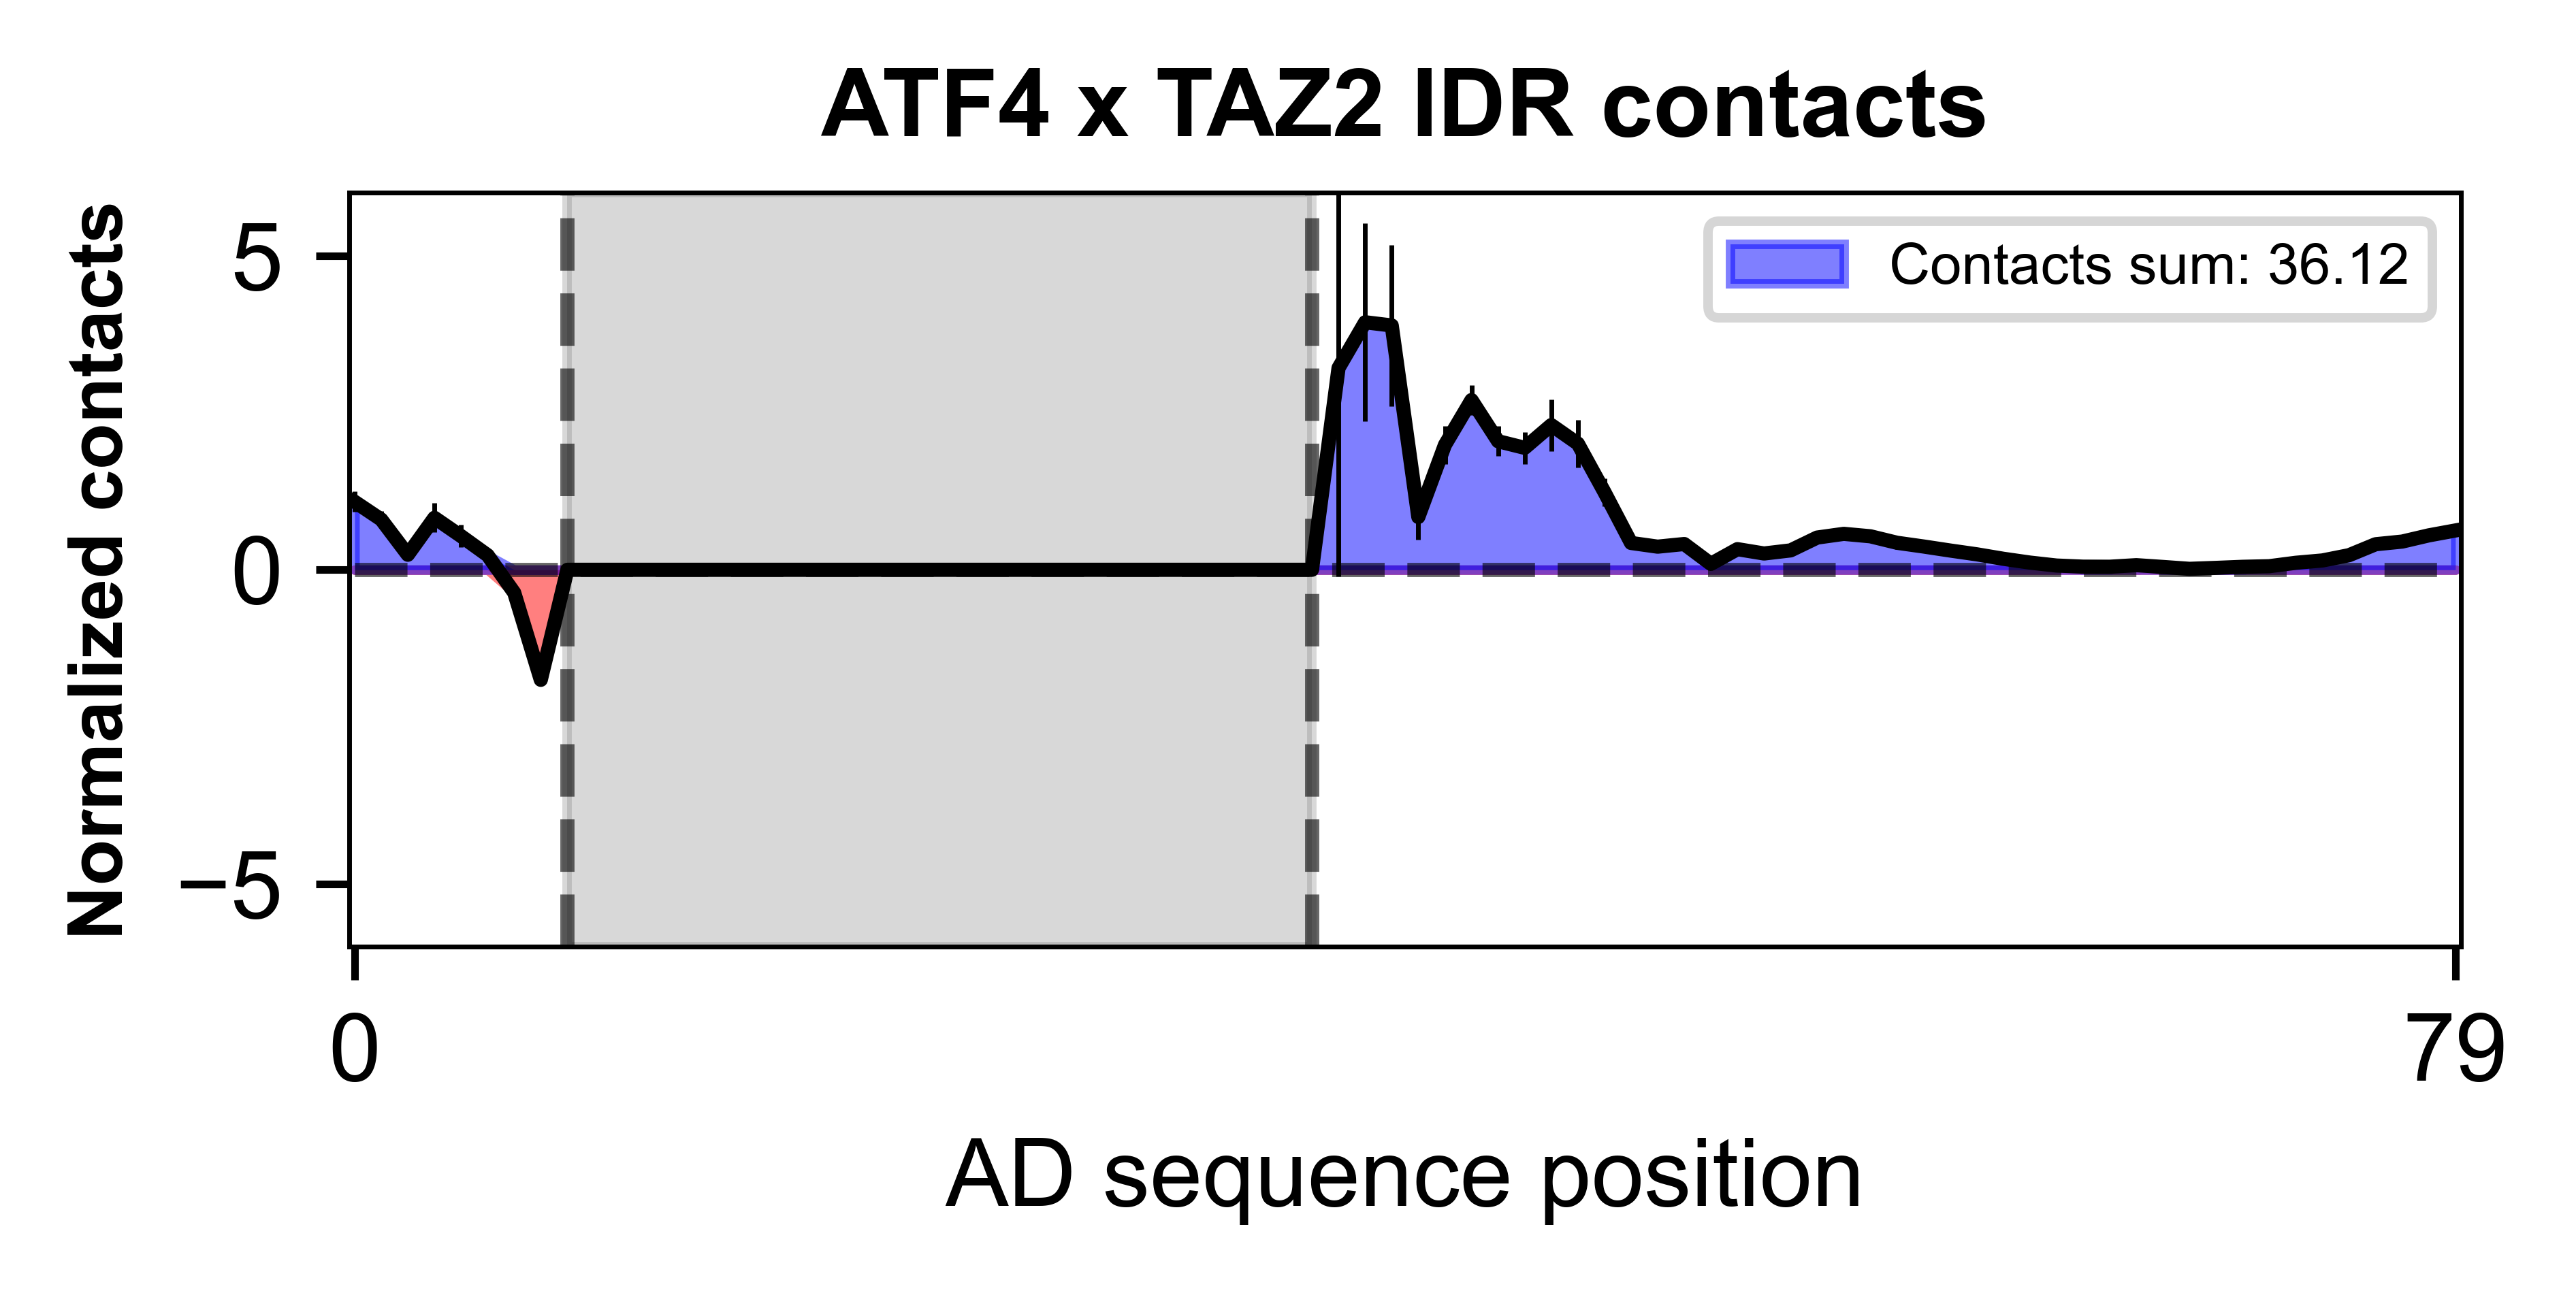

In [19]:
# for v in variants:
for v in test_variants:
    idr = data[v]['idr_contact_mean']
    idr_ev = EV_data[v]['idr_contact_mean']
    idr_sem = data[v]['idr_contact_stderr'] + EV_data[v]['idr_contact_stderr']
    seq_len = len(idr)

    fig, ax = plt.subplots(figsize=(4,2),dpi=500)
    ax.set_ylim([-6,6])
    ax.set_xlim([-0.2,79.2])
    ax.set_title(f'ATF4 x TAZ2 IDR contacts', fontsize=10, fontweight='bold')

    diff = idr - idr_ev
    pos_interaction = [y if y >= 0.05 else 0 for y in diff]
    neg_interaction = [y if y < 0.05 else 0 for y in diff]

    ax.errorbar(x=np.arange(seq_len), y=diff, yerr=idr_sem, color='black', elinewidth=0.5, rasterized=True)
    ax.fill_between( np.arange(seq_len), neg_interaction, np.zeros(seq_len), color='red', alpha=0.5, rasterized=True)
    ax.fill_between( np.arange(seq_len), pos_interaction, np.zeros(seq_len), color='blue', alpha=0.5, 
                     label=f'Contacts sum: {np.around(np.sum(diff), 2)}', rasterized=True)

    for idx in [data[v]['fixed_res'][0]-2,data[v]['fixed_res'][1]+2]:
        ax.vlines(idx-1, -6, 6, color='k',linestyle='--', alpha=0.6, rasterized=True)
    ax.hlines(0, 0, seq_len, color='k',linestyle='--', alpha=0.6, rasterized=True)
    ax.fill_betweenx(np.linspace(-6,6,100), 
                      [data[v]['fixed_res'][0]-3]*100, 
                      [data[v]['fixed_res'][1]+1]*100,
                     color='gray', alpha=0.3, rasterized=True)

    ax.set_ylabel('Normalized contacts', fontsize=8, fontweight='bold')
    ax.set_xlabel('AD sequence position')
    ax.set_xticks([0, 79])
    plt.legend(fontsize=6)
    plt.tight_layout()
    

    # save out as pdf
    with PdfPages(f'{output_dir}/{v}_IDRcontact_diff_plot.pdf') as pdf:
        pdf.savefig(fig, dpi=500) 
    

In [ ]:
# EV comparison
# for v in variants:
for v in test_variants:
    fd = data[v]['fd_contact_mean']
    fd_ev = EV_data[v]['fd_contact_mean']    
    fd_sem = data[v]['fd_contact_stderr'] + EV_data[v]['fd_contact_stderr']

    plt.figure(figsize=(4,2),dpi=300)
    plt.ylim([-5,5])
    plt.title(f'{v}', fontsize=8)


    diff = fd - fd_ev
    pos_interaction = [y if y >= 0.05 else 0 for y in diff]
    neg_interaction = [y if y < 0.05 else 0 for y in diff]

    plt.errorbar(x=np.arange(len(fd)), y=diff, yerr=fd_sem, color='black', elinewidth=0.5)
    plt.fill_between( np.arange(len(fd)), neg_interaction, np.zeros(len(fd)), color='red', alpha=0.5)
    plt.fill_between( np.arange(len(fd)), pos_interaction, np.zeros(len(fd)), color='blue', alpha=0.5,
                     label=f'Contacts sum: {np.around(np.sum(diff), 2)}')
    plt.hlines(0, 0, 80, color='k',linestyle='--', alpha=0.6)


    plt.ylabel('Normalized IDR contacts', fontsize=8, fontweight='bold')
    plt.xlabel('TAZ2 sequence position')
    plt.legend(fontsize=6)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/{v}_FDcontact_diff_plot.png')
    plt.show()

In [47]:
## Save out IDR and FD contact vectors for use in PyMOL
taz2_contact_sum = data['WT_TAF6L_TAZ2_WT']['cmap'].sum(axis=0)
taf6l_contact_sum = data['WT_TAF6L_TAZ2_WT']['cmap'].sum(axis=1)

np.savetxt(f'{output_dir}/WT_TAF6L_summed_contacts_IDR.csv', taf6l_contact_sum)
np.savetxt(f'{output_dir}/WT_TAF6L_summed_contacts_TAZ2.csv', taz2_contact_sum)


In [ ]:
## Normalize contact plots to WT instead of EV

for v in test_variants:
    idr = data[v]['idr_contact_mean']
    idr_wt = data['WT_TAF6L_TAZ2_WT']['idr_contact_mean']
    idr_sem = data[v]['idr_contact_stderr'] + data['WT_TAF6L_TAZ2_WT']['idr_contact_stderr']
    seq_len = len(idr)
    
#     idr = idr - EV_data[v]['idr_contact_mean']
#     idr_wt = idr_wt - EV_data['WT_ATF4_TAZ2_WT']['idr_contact_mean']

    plt.figure(figsize=(4,2),dpi=300)
    plt.ylim([-5,5])
    plt.title(f'{v[:-8]} - WT_TAF6L', fontsize=8)

    diff = idr - idr_wt
    pos_interaction = [y if y >= 0.05 else 0 for y in diff]
    neg_interaction = [y if y < 0.05 else 0 for y in diff]

    plt.errorbar(x=np.arange(seq_len), y=diff, yerr=idr_sem, color='black', elinewidth=0.5)
    plt.fill_between( np.arange(seq_len), neg_interaction, np.zeros(seq_len), color='red', alpha=0.5)
    plt.fill_between( np.arange(seq_len), pos_interaction, np.zeros(seq_len), color='blue', alpha=0.5, 
                     label=f'Contacts sum: {np.around(np.sum(diff), 2)}')

    for idx in [data[v]['fixed_res'][0]-2,data[v]['fixed_res'][1]+2]:
        plt.vlines(idx-1, -5, 5, color='k',linestyle='--', alpha=0.6)
    plt.hlines(0, 0, seq_len, color='k',linestyle='--', alpha=0.6)
    plt.fill_betweenx(np.linspace(-5,5,100), 
                      [data[v]['fixed_res'][0]-3]*100, 
                      [data[v]['fixed_res'][1]+1]*100,
                     color='gray', alpha=0.3)

    plt.ylabel('Norm. contacts\n(WT)', fontsize=8, fontweight='bold')
    plt.xlabel('AD sequence position')
    plt.legend(fontsize=6)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/{v}_WTnorm_IDRcontact_diff_plot.png')
    plt.show()

In [ ]:
# EV comparison
for v in test_variants:
    fd = data[v]['fd_contact_mean']
    fd_wt = data['WT_TAF6L_TAZ2_WT']['fd_contact_mean']    
    fd_sem = data[v]['fd_contact_stderr'] + data['WT_TAF6L_TAZ2_WT']['fd_contact_stderr']

    plt.figure(figsize=(4,2),dpi=300)
    plt.ylim([-5,5])
    plt.title(f'{v[:-8]} - WT_TAF6L', fontsize=8)


    diff = fd - fd_wt
    pos_interaction = [y if y >= 0.05 else 0 for y in diff]
    neg_interaction = [y if y < 0.05 else 0 for y in diff]

    plt.errorbar(x=np.arange(len(fd)), y=diff, yerr=fd_sem, color='black', elinewidth=0.5)
    plt.fill_between( np.arange(len(fd)), neg_interaction, np.zeros(len(fd)), color='red', alpha=0.5)
    plt.fill_between( np.arange(len(fd)), pos_interaction, np.zeros(len(fd)), color='blue', alpha=0.5,
                     label=f'Contacts sum: {np.around(np.sum(diff), 2)}')
    plt.hlines(0, 0, 80, color='k',linestyle='--', alpha=0.6)


    plt.ylabel('Norm. contacts\n(WT)', fontsize=8, fontweight='bold')
    plt.xlabel('TAZ2 sequence position')
    plt.legend(fontsize=6)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/{v}_WTnorm_FDcontact_diff_plot.png')
    plt.show()

## Boxplots

In [5]:
## TODO:
# Compute mean EV contact freqs for each structure
# For each WT sim
    # Compute contact freq
    # Get associated EV data
    # Normalize by this EV data
    # Compute contact score
    # Add score to list
# Plot all replicates
def compute_mean_contact_map(path_list, threshold=10):
    cmaps = []
    for path in path_list:
        pdb = f'{path}/EquilMC_END.pdb'
        xtc = f'{path}/StandardMC_traj.xtc'
        traj, prot = load_trajectory(pdb, xtc, stride=1)
        dmap = get_interchain_dmap(prot, mode='COM')
        cmap = get_contact_freq_map(dmap, threshold)
        cmaps.append(cmap)
        
    cmaps = np.dstack(cmaps)
    return cmaps.mean(axis=2)

def compute_contact_score_indiv_reps(sim_paths, ev_struct_map, ev_cmaps, idr_res_idxs):
    contact_sum_vals = []

    for i, sim_path in enumerate(sim_paths):
#         plt.figure(i)
        cmap = compute_mean_contact_map([sim_path])
        ev_struct = ev_struct_map[i]
        ev_cmap = ev_cmaps[ev_struct]
        
        norm_cmap = cmap - ev_cmap
    
        norm_cmap[idr_res_idxs[0]:idr_res_idxs[1], :] = 0
#         plt.matshow(norm_cmap, vmin=-1, vmax=1, cmap='seismic_r')
#         plt.show()
        
        contact_score = np.sum(norm_cmap)
        contact_sum_vals.append(contact_score)
    
    return contact_sum_vals




In [12]:
redo_root = '/work/degriffith/TADs/fixed_TAD_sims/p300_coactivators/flanking_idr_sims/sims/sept2023_sims'

In [8]:
# cMYB-KIX vs ATF4-TAZ2
round1_root = '/work/degriffith/TADs/fixed_TAD_sims/p300_coactivators/flanking_idr_sims/sims/round1_IDR_variants_TAZ2_WT'
output_dir = '/home/degriffith/projects/TADs/bound_sims/flanking_contacts/p300_coactivators_analyses/figures/round1_variants'

psw_path = f"{round1_root}/structure_1/WT_ATF4_TAZ2_WT/coil_start/1/PSWFILE.psw"
psw_data = read_psw(psw_path)
fixed_residue_idxs = get_fixed_idr_residues(psw_data)
atf4_idr_residue_idxs = [fixed_residue_idxs[0]-3, fixed_residue_idxs[1]+2]

ATF4_WT_EV_paths = {'atf4_wt_1':   [f'{round1_root}/structure_1/ev/WT_ATF4_TAZ2_WT/coil_start/1',
                                    f'{round1_root}/structure_1/ev2/WT_ATF4_TAZ2_WT/coil_start/1',
                                    f'{round1_root}/structure_1/ev2/WT_ATF4_TAZ2_WT/coil_start/2'],
                    'atf4_wt_2':   [f'{round1_root}/structure_2/ev/WT_ATF4_TAZ2_WT/coil_start/1',
                                    f'{round1_root}/structure_2/ev2/WT_ATF4_TAZ2_WT/coil_start/1',
                                    f'{round1_root}/structure_2/ev2/WT_ATF4_TAZ2_WT/coil_start/2'],
                    'atf4_wt_3':   [f'{round1_root}/structure_3/ev/WT_ATF4_TAZ2_WT/coil_start/1',
                                    f'{round1_root}/structure_3/ev2/WT_ATF4_TAZ2_WT/coil_start/1',
                                    f'{round1_root}/structure_3/ev2/WT_ATF4_TAZ2_WT/coil_start/2']
                   }

# Get mean EV cmaps
ATF4_WT_EV_cmaps = {}
for name, path_list in ATF4_WT_EV_paths.items():
    ATF4_WT_EV_cmaps[name] = compute_mean_contact_map(path_list)

Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...


In [6]:
redo_root = '/work/degriffith/TADs/fixed_TAD_sims/p300_coactivators/flanking_idr_sims/sims/sept2023_sims'

psw_path = f"{redo_root}/cMYB_1_KIX/coil_start/1/PSWFILE.psw"
psw_data = read_psw(psw_path)
fixed_residue_idxs = get_fixed_idr_residues(psw_data)
cmyb_idr_residue_idxs = [fixed_residue_idxs[0]-3, fixed_residue_idxs[1]+2]

cMYB_EV_paths =    {'cmyb_wt_1':   [f'{redo_root}/ev/cMYB_1_KIX/coil_start/1',
                                    f'{redo_root}/ev/cMYB_1_KIX/coil_start/2',
                                    f'{redo_root}/ev/cMYB_1_KIX/coil_start/3',
                                    f'{redo_root}/ev/cMYB_1_KIX/coil_start/4'],
                    'cmyb_wt_2':   [f'{redo_root}/ev/cMYB_2_KIX/coil_start/1',
                                    f'{redo_root}/ev/cMYB_2_KIX/coil_start/2',
                                    f'{redo_root}/ev/cMYB_2_KIX/coil_start/3',
                                    f'{redo_root}/ev/cMYB_2_KIX/coil_start/4'],
                    'cmyb_wt_3':   [f'{redo_root}/ev/cMYB_3_KIX/coil_start/1',
                                    f'{redo_root}/ev/cMYB_3_KIX/coil_start/2',
                                    f'{redo_root}/ev/cMYB_3_KIX/coil_start/3',
                                    f'{redo_root}/ev/cMYB_3_KIX/coil_start/4']
                   }

# Get mean EV cmaps
cMYB_EV_cmaps = {}
for name, path_list in cMYB_EV_paths.items():
    cMYB_EV_cmaps[name] = compute_mean_contact_map(path_list)

Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...


In [9]:
ev_struct_map = {0:'atf4_wt_1',1:'atf4_wt_1',2:'atf4_wt_1',3:'atf4_wt_1',
                 4:'atf4_wt_2',5:'atf4_wt_2',6:'atf4_wt_2',7:'atf4_wt_2',
                 8:'atf4_wt_3',9:'atf4_wt_3',10:'atf4_wt_3',11:'atf4_wt_3',}

full_energy_sim_paths = [f'{round1_root}/structure_1/WT_ATF4_TAZ2_WT/coil_start/1',
                         f'{round1_root}/structure_1/WT_ATF4_TAZ2_WT/coil_start/2',
                         f'{round1_root}/structure_1/WT_ATF4_TAZ2_WT/coil_start/3',
                         f'{round1_root}/structure_1/WT_ATF4_TAZ2_WT/coil_start/4',
                         f'{round1_root}/structure_2/WT_ATF4_TAZ2_WT/coil_start/1',
                         f'{round1_root}/structure_2/WT_ATF4_TAZ2_WT/coil_start/2',
                         f'{round1_root}/structure_2/WT_ATF4_TAZ2_WT/coil_start/3',
                         f'{round1_root}/structure_2/WT_ATF4_TAZ2_WT/coil_start/4',
                         f'{round1_root}/structure_3/WT_ATF4_TAZ2_WT/coil_start/1',
                         f'{round1_root}/structure_3/WT_ATF4_TAZ2_WT/coil_start/2',
                         f'{round1_root}/structure_3/WT_ATF4_TAZ2_WT/coil_start/3',
                         f'{round1_root}/structure_3/WT_ATF4_TAZ2_WT/coil_start/4']
atf4_scores = compute_contact_score_indiv_reps(full_energy_sim_paths, ev_struct_map, ATF4_WT_EV_cmaps, atf4_idr_residue_idxs)

Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...


In [8]:
ev_struct_map = {0:'cmyb_wt_1',1:'cmyb_wt_1',2:'cmyb_wt_1',3:'cmyb_wt_1',
                 4:'cmyb_wt_2',5:'cmyb_wt_2',6:'cmyb_wt_2',7:'cmyb_wt_2',
                 8:'cmyb_wt_3',9:'cmyb_wt_3',10:'cmyb_wt_3',11:'cmyb_wt_3',}

full_energy_sim_paths = [f'{redo_root}/cMYB_1_KIX/coil_start/1',
                         f'{redo_root}/cMYB_1_KIX/coil_start/2',
                         f'{redo_root}/cMYB_1_KIX/coil_start/3',
                         f'{redo_root}/cMYB_1_KIX/coil_start/4',
                         f'{redo_root}/cMYB_2_KIX/coil_start/1',
                         f'{redo_root}/cMYB_2_KIX/coil_start/2',
                         f'{redo_root}/cMYB_2_KIX/coil_start/3',
                         f'{redo_root}/cMYB_2_KIX/coil_start/4',
                         f'{redo_root}/cMYB_3_KIX/coil_start/1',
                         f'{redo_root}/cMYB_3_KIX/coil_start/2',
                         f'{redo_root}/cMYB_3_KIX/coil_start/3',
                         f'{redo_root}/cMYB_3_KIX/coil_start/4']
cmyb_scores = compute_contact_score_indiv_reps(full_energy_sim_paths, ev_struct_map, cMYB_EV_cmaps, cmyb_idr_residue_idxs)

Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...


In [11]:
atf4_scores

[93.3388740138166,
 82.57225596839048,
 33.01568168208083,
 71.6983238992094,
 12.630553997957271,
 20.44447356453364,
 21.00500700900124,
 44.09481738616315,
 40.58537694430692,
 30.632053335221695,
 32.85980911767637,
 40.4072148271992]

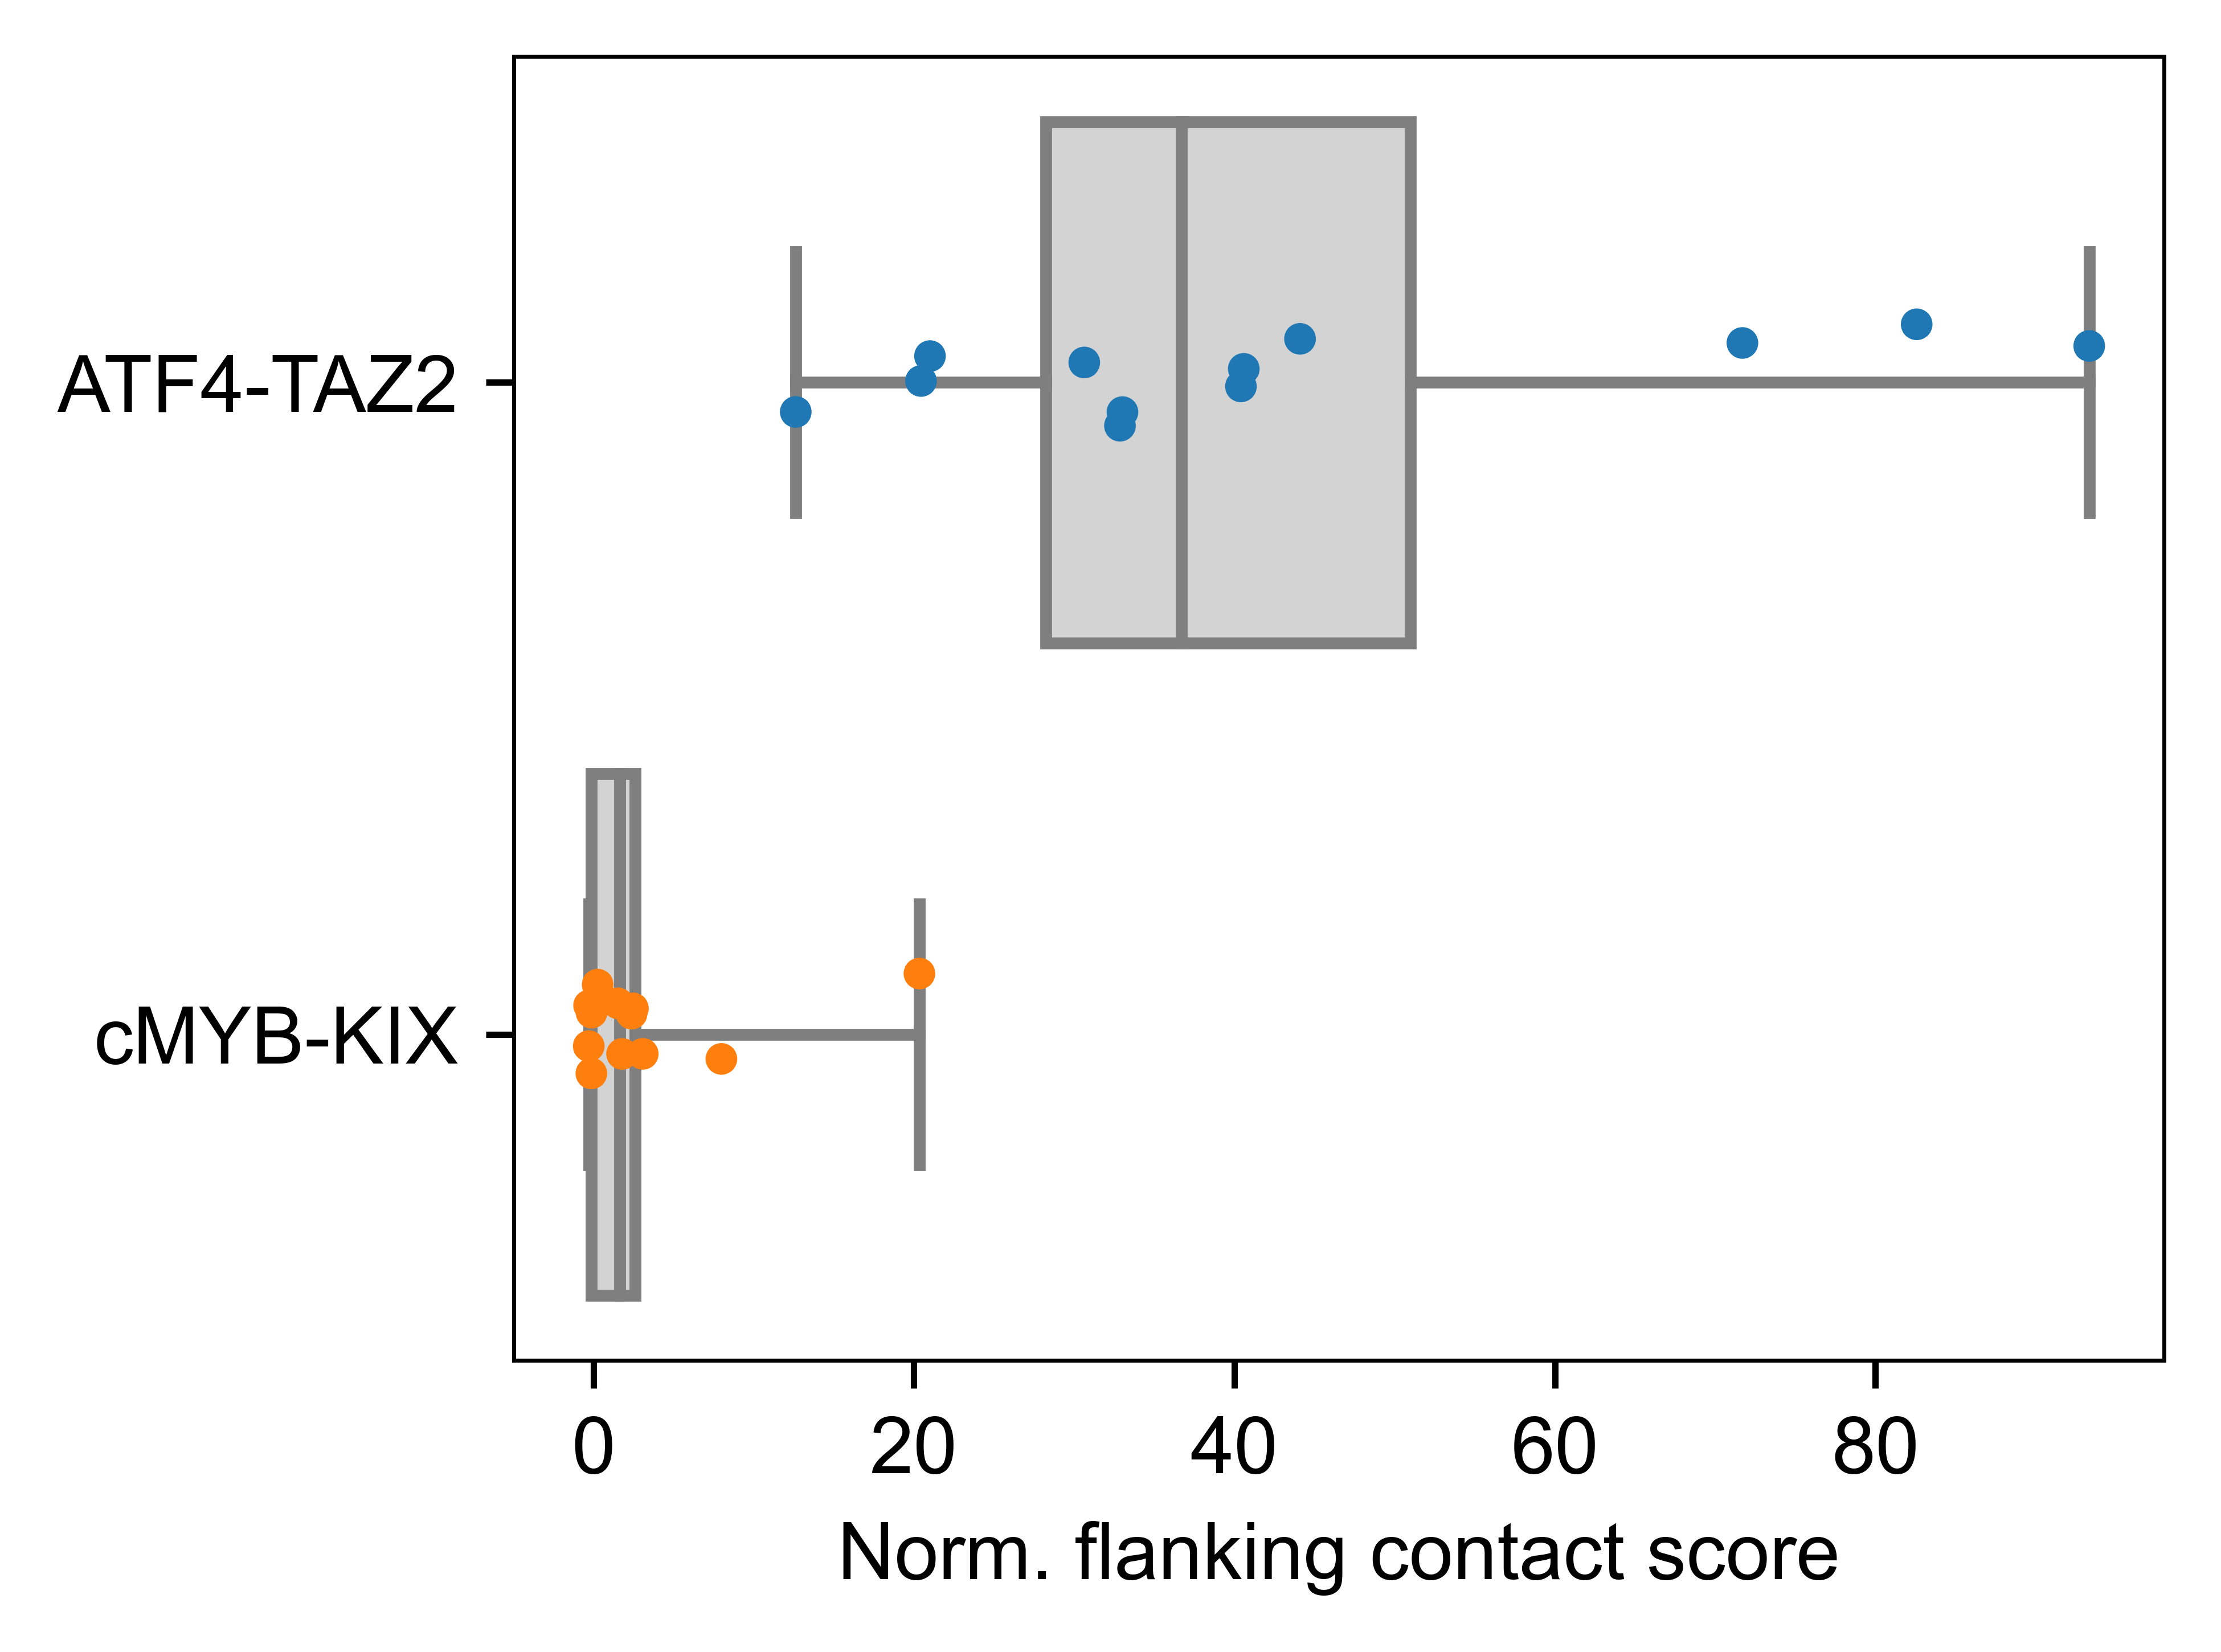

In [12]:
output_dir = '/home/degriffith/projects/TADs/bound_sims/flanking_contacts/p300_coactivators_analyses/figures/round1_variants'

fig, ax = plt.subplots(figsize=(4,3), dpi=500)

sns.stripplot(data=np.vstack([atf4_scores, cmyb_scores]).T, orient='h', ax=ax, s=4, rasterized=True)
sns.boxplot(data=np.vstack([atf4_scores, cmyb_scores]).T, color='lightgray', whis=10, orient='h', ax=ax)
ax.set_yticks([0,1], ['ATF4-TAZ2', 'cMYB-KIX'])
ax.set_xlabel('Norm. flanking contact score')

plt.tight_layout()

# save out as pdf
with PdfPages(f'{output_dir}/ATF4-TAZ2_vs_cMYB-KIX_contacts_boxplot.pdf') as pdf:
    pdf.savefig(fig, dpi=500) 

In [10]:
# TAZ2-sufficiency mutants

round1_sufficiency_constructs = ['SufficiencyNegCharge_ATF4_8_TAZ2_WT',
                                  'SufficiencyHydrophobic_ATF4_8_TAZ2_WT',
                                  'SufficiencyNegChargeHydrophobic_ATF4_8_TAZ2_WT']

ev_struct_map = {0:1, 1:1, 2:1, 3:1, 4:2, 5:2, 6:2, 7:2, 8:3, 9:3, 10:3, 11:3}

psw_path = f"{round1_root}/structure_1/WT_ATF4_TAZ2_WT/coil_start/1/PSWFILE.psw"
psw_data = read_psw(psw_path)
fixed_residue_idxs = get_fixed_idr_residues(psw_data)
atf4_idr_residue_idxs = [fixed_residue_idxs[0]-3, fixed_residue_idxs[1]+2]

suff_score_dict = {}
for name in round1_sufficiency_constructs:
    print(name)
    print('  EV')
    # get EV cmaps
    ev_paths = {1:[f'{round1_root}/structure_1/ev/{name}/coil_start/1',
                     f'{round1_root}/structure_1/ev2/{name}/coil_start/1',
                     f'{round1_root}/structure_1/ev2/{name}/coil_start/2'],
                2:[f'{round1_root}/structure_2/ev/{name}/coil_start/1',
                     f'{round1_root}/structure_2/ev2/{name}/coil_start/1',
                     f'{round1_root}/structure_2/ev2/{name}/coil_start/2'],
                3:[f'{round1_root}/structure_3/ev/{name}/coil_start/1',
                     f'{round1_root}/structure_3/ev2/{name}/coil_start/1',
                     f'{round1_root}/structure_3/ev2/{name}/coil_start/2']}
    sufficiency_EV_cmaps = {}
    for idx, path_list in ev_paths.items():
        sufficiency_EV_cmaps[idx] = compute_mean_contact_map(path_list)
        
    
    # Get scores
    paths=[]
    for i in range(12):
        struct = 1 + i//4
        repl = 1 + i%4
        
        paths.append(f'{round1_root}/structure_{struct}/{name}/coil_start/{repl}')
        
    print('  Full')
    sufficiency_scores = compute_contact_score_indiv_reps(paths, ev_struct_map, 
                                                          sufficiency_EV_cmaps, atf4_idr_residue_idxs)

        
    
    suff_score_dict[name] = sufficiency_scores
    


SufficiencyNegCharge_ATF4_8_TAZ2_WT
  EV
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
  Full
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein t

In [13]:
name = 'Sufficiency_Inert_ExtendedMotif_ATF4'
print('  EV')
# get EV cmaps
ev_paths = {1:[f'{redo_root}/ev/{name}_1_TAZ2/coil_start/1',
               f'{redo_root}/ev/{name}_1_TAZ2/coil_start/2',
               f'{redo_root}/ev/{name}_1_TAZ2/coil_start/3'],
            2:[f'{redo_root}/ev/{name}_2_TAZ2/coil_start/1',
               f'{redo_root}/ev/{name}_2_TAZ2/coil_start/2',
               f'{redo_root}/ev/{name}_2_TAZ2/coil_start/3'],
            3:[f'{redo_root}/ev/{name}_3_TAZ2/coil_start/1',
               f'{redo_root}/ev/{name}_3_TAZ2/coil_start/2',
               f'{redo_root}/ev/{name}_3_TAZ2/coil_start/3']}
sufficiency_EV_cmaps = {}
for idx, path_list in ev_paths.items():
    sufficiency_EV_cmaps[idx] = compute_mean_contact_map(path_list)

# Get scores
paths=[]
for i in range(12):
    struct = 1 + i//4
    repl = 1 + i%4

    paths.append(f'{redo_root}/ev/{name}_{struct}_TAZ2/coil_start/{repl}')

print('  Full')
sufficiency_scores = compute_contact_score_indiv_reps(paths, ev_struct_map, 
                                                      sufficiency_EV_cmaps, atf4_idr_residue_idxs)

suff_score_dict[name] = sufficiency_scores

  EV
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
  Full
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map..

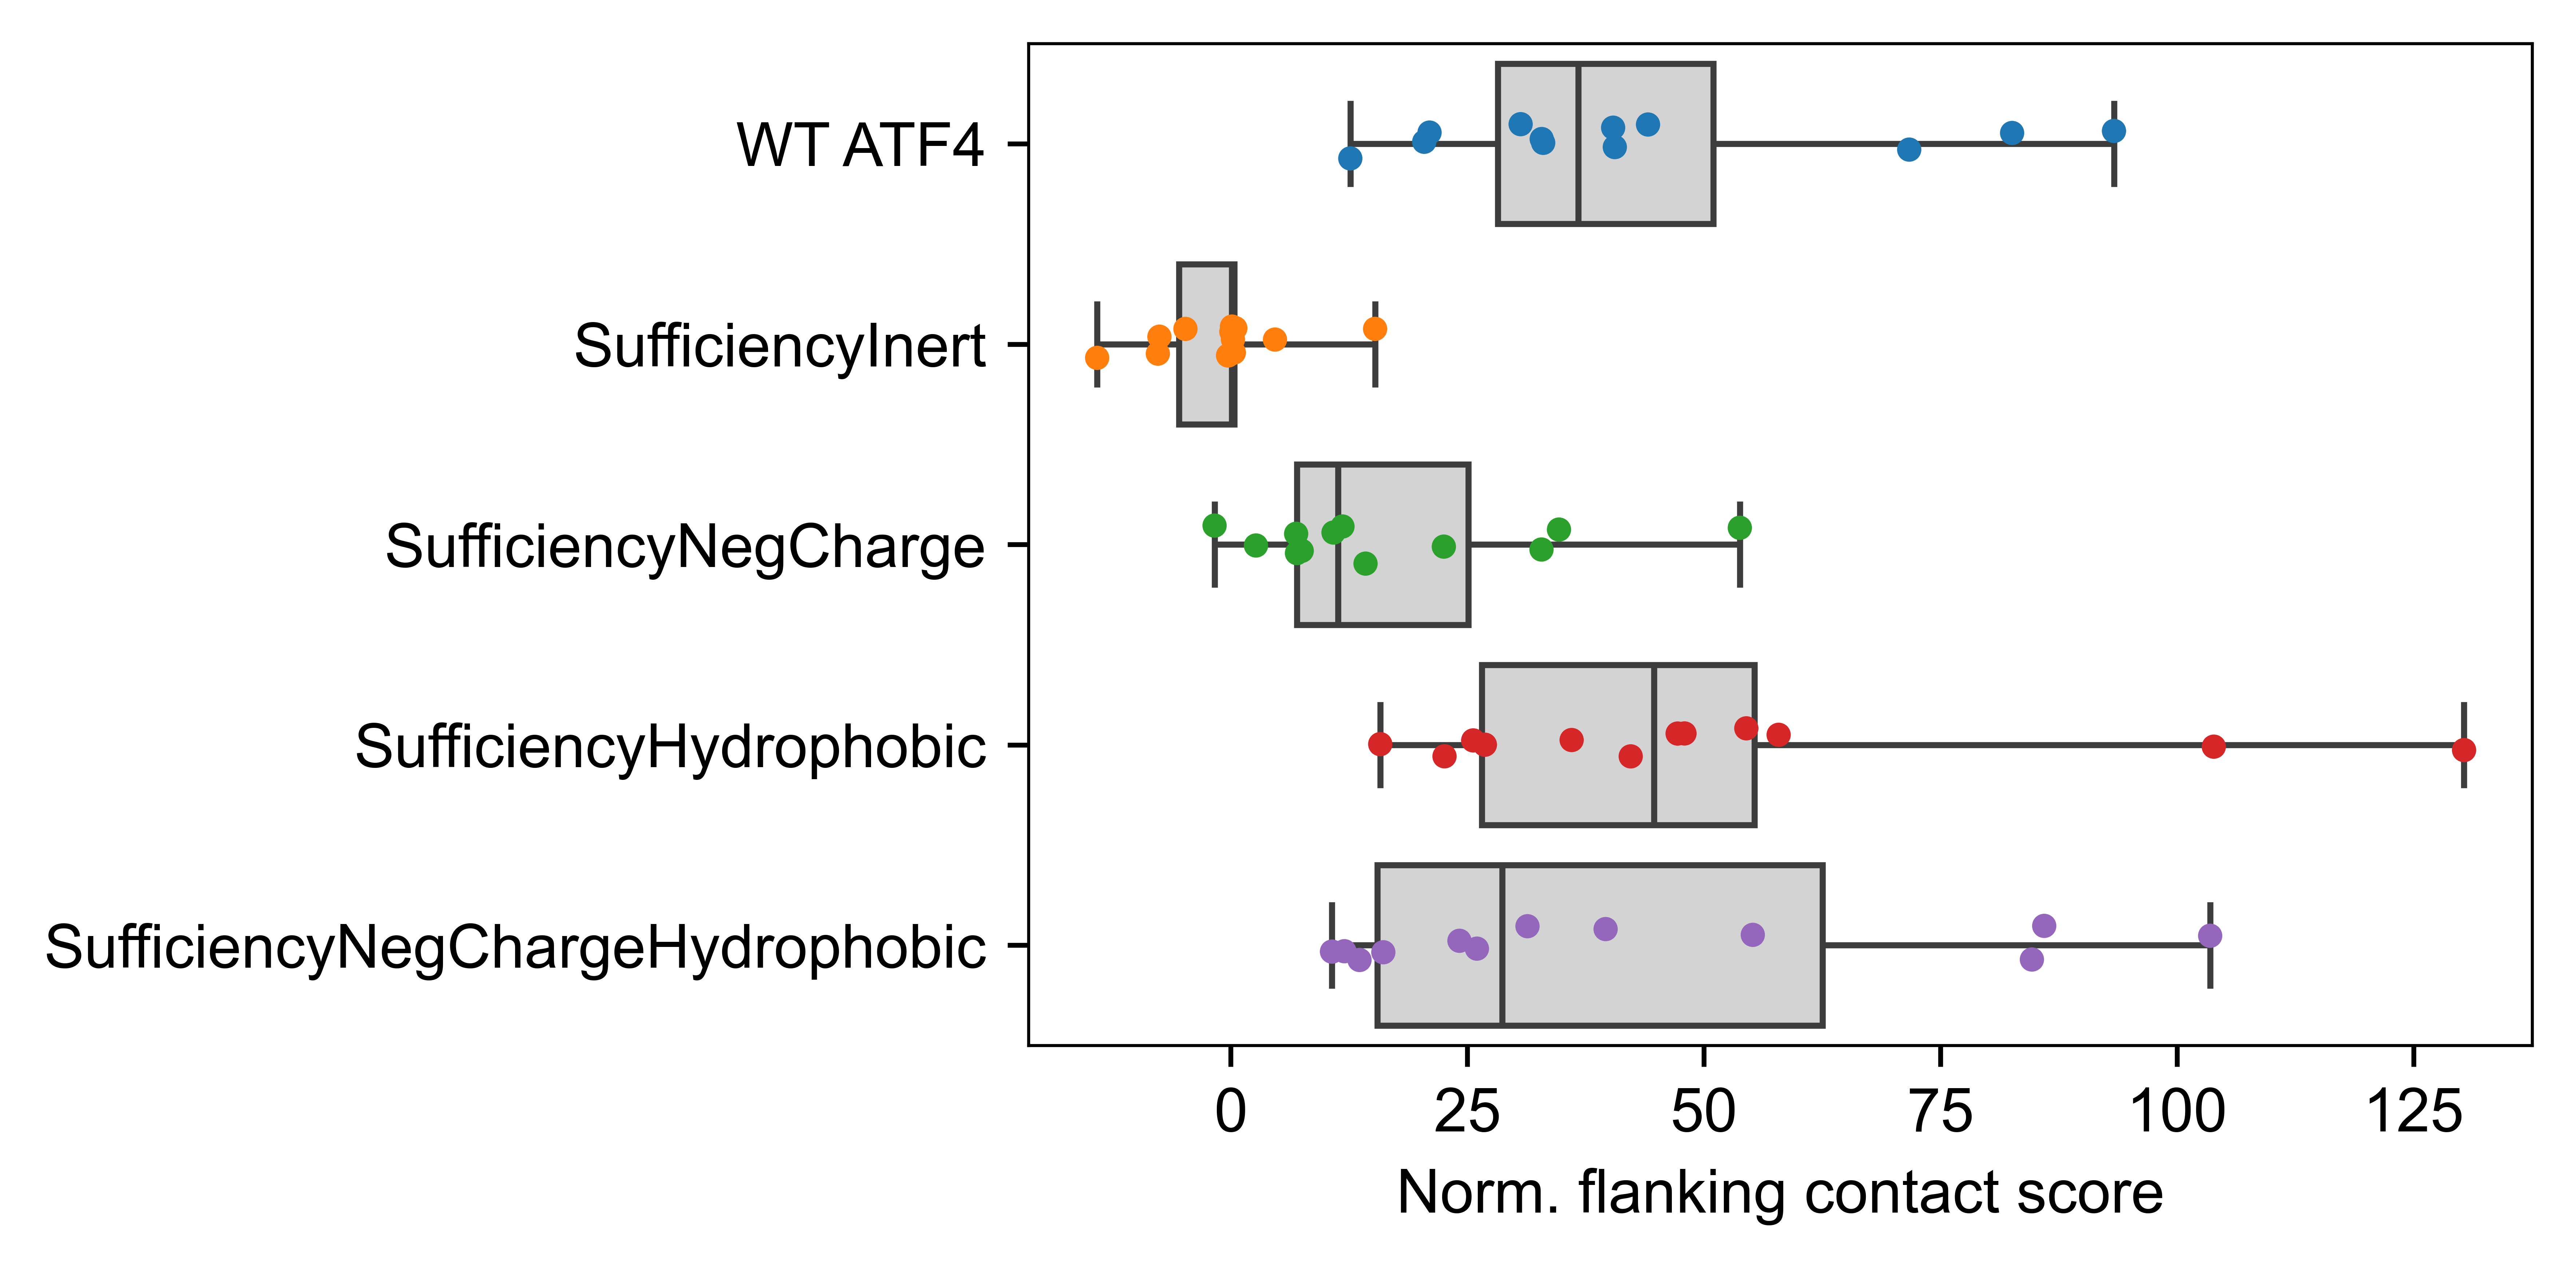

In [17]:
fig, ax = plt.subplots(figsize=(6,3), dpi=600)

dataset= np.vstack([atf4_scores, suff_score_dict['Sufficiency_Inert_ExtendedMotif_ATF4'],
                    suff_score_dict['SufficiencyNegCharge_ATF4_8_TAZ2_WT'],
                    suff_score_dict['SufficiencyHydrophobic_ATF4_8_TAZ2_WT'],
                    suff_score_dict['SufficiencyNegChargeHydrophobic_ATF4_8_TAZ2_WT']]).T

sns.stripplot(data=dataset, orient='h', ax=ax, s=4)
sns.boxplot(data=dataset, color='lightgray', whis=10, orient='h', ax=ax)
ax.set_yticks([0,1,2,3,4], ['WT ATF4', 'SufficiencyInert',
                            'SufficiencyNegCharge', 
                            'SufficiencyHydrophobic', 'SufficiencyNegChargeHydrophobic'])
ax.set_xticks([0,25,50,75,100,125])
ax.set_xlabel('Norm. flanking contact score')

plt.tight_layout()

plt.savefig(f'{output_dir}/wtATF_vs_sufficiencyATF4_TAZ2_contacts_boxplot.eps')

# save out as pdf
# with PdfPages(f'{output_dir}/wtATF_vs_sufficiencyATF4_TAZ2_contacts_boxplot.pdf') as pdf:
#     pdf.savefig(fig, dpi=500) 

## Compare WT ATF4 with sufficiency constructs
* Get heatmaps
* Find hotspots

In [10]:
redo_root = '/work/degriffith/TADs/fixed_TAD_sims/p300_coactivators/flanking_idr_sims/sims/sept2023_sims'
round1_root = '/work/degriffith/TADs/fixed_TAD_sims/p300_coactivators/flanking_idr_sims/sims/round1_IDR_variants_TAZ2_WT'
output_dir = '/home/degriffith/projects/TADs/bound_sims/flanking_contacts/p300_coactivators_analyses/figures/round1_variants'
sufficiency_cmaps = {'full':{}, 'ev':{}}

In [11]:
name = 'Sufficiency_Inert_ExtendedMotif_ATF4'
sufficiency_cmaps['ev']['SufficiencyInert'] = {}
print('  EV')
# get EV cmaps
ev_paths = {1:[f'{redo_root}/ev/{name}_1_TAZ2/coil_start/1',
               f'{redo_root}/ev/{name}_1_TAZ2/coil_start/2',
               f'{redo_root}/ev/{name}_1_TAZ2/coil_start/3'],
            2:[f'{redo_root}/ev/{name}_2_TAZ2/coil_start/1',
               f'{redo_root}/ev/{name}_2_TAZ2/coil_start/2',
               f'{redo_root}/ev/{name}_2_TAZ2/coil_start/3'],
            3:[f'{redo_root}/ev/{name}_3_TAZ2/coil_start/1',
               f'{redo_root}/ev/{name}_3_TAZ2/coil_start/2',
               f'{redo_root}/ev/{name}_3_TAZ2/coil_start/3']}
for idx, path_list in ev_paths.items():
    sufficiency_cmaps['ev']['SufficiencyInert'][idx] = compute_mean_contact_map(path_list)

  EV
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...


In [13]:
round1_sufficiency_constructs = ['WT_ATF4_TAZ2_WT',
                                  'SufficiencyNegCharge_ATF4_8_TAZ2_WT',
                                  'SufficiencyHydrophobic_ATF4_8_TAZ2_WT',
                                  'SufficiencyNegChargeHydrophobic_ATF4_8_TAZ2_WT']

ev_struct_map = {0:1, 1:1, 2:1, 3:1, 4:2, 5:2, 6:2, 7:2, 8:3, 9:3, 10:3, 11:3}

psw_path = f"{round1_root}/structure_1/WT_ATF4_TAZ2_WT/coil_start/1/PSWFILE.psw"
psw_data = read_psw(psw_path)
fixed_residue_idxs = get_fixed_idr_residues(psw_data)
atf4_idr_residue_idxs = [fixed_residue_idxs[0]-3, fixed_residue_idxs[1]+2]

for name in round1_sufficiency_constructs:
    short_name = name.split('_')[0]
    sufficiency_cmaps['ev'][short_name] = {}
    print(short_name)
    print('  EV')
    # get EV cmaps
    ev_paths = {1:[f'{round1_root}/structure_1/ev/{name}/coil_start/1',
                     f'{round1_root}/structure_1/ev2/{name}/coil_start/1',
                     f'{round1_root}/structure_1/ev2/{name}/coil_start/2'],
                2:[f'{round1_root}/structure_2/ev/{name}/coil_start/1',
                     f'{round1_root}/structure_2/ev2/{name}/coil_start/1',
                     f'{round1_root}/structure_2/ev2/{name}/coil_start/2'],
                3:[f'{round1_root}/structure_3/ev/{name}/coil_start/1',
                     f'{round1_root}/structure_3/ev2/{name}/coil_start/1',
                     f'{round1_root}/structure_3/ev2/{name}/coil_start/2']}

    for idx, path_list in ev_paths.items():
        sufficiency_cmaps['ev'][short_name][idx] = compute_mean_contact_map(path_list)

WT
  EV
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
SufficiencyNegCharge
  EV
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
C

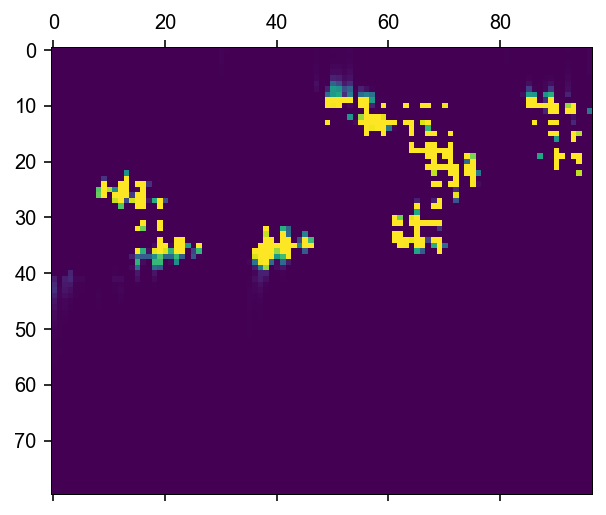

In [20]:
plt.matshow(sufficiency_cmaps['ev']['SufficiencyNegCharge'][1])

In [22]:
name = 'Sufficiency_Inert_ExtendedMotif_ATF4'
sufficiency_cmaps['full']['SufficiencyInert'] = {}
print('  full')
# get full cmaps
full_paths = {1:[f'{redo_root}/{name}_1_TAZ2/coil_start/1',
               f'{redo_root}/{name}_1_TAZ2/coil_start/2',
               f'{redo_root}/{name}_1_TAZ2/coil_start/3',
               f'{redo_root}/{name}_1_TAZ2/coil_start/4'],
            2:[f'{redo_root}/{name}_2_TAZ2/coil_start/1',
               f'{redo_root}/{name}_2_TAZ2/coil_start/2',
               f'{redo_root}/{name}_2_TAZ2/coil_start/3',
               f'{redo_root}/{name}_2_TAZ2/coil_start/4'],
            3:[f'{redo_root}/{name}_3_TAZ2/coil_start/1',
               f'{redo_root}/{name}_3_TAZ2/coil_start/2',
               f'{redo_root}/{name}_3_TAZ2/coil_start/3',
               f'{redo_root}/{name}_3_TAZ2/coil_start/4']}
for idx, path_list in full_paths.items():
    sufficiency_cmaps['full']['SufficiencyInert'][idx] = compute_mean_contact_map(path_list)

  full
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...


In [24]:
for name in round1_sufficiency_constructs:
    short_name = name.split('_')[0]
    sufficiency_cmaps['full'][short_name] = {}
    print()
    print(short_name)
    print('  full')
    # get full cmaps
    full_paths = {1:[f'{round1_root}/structure_1/{name}/coil_start/1',
                   f'{round1_root}/structure_1/{name}/coil_start/2',
                   f'{round1_root}/structure_1/{name}/coil_start/3',
                   f'{round1_root}/structure_1/{name}/coil_start/4'],
                2:[f'{round1_root}/structure_2/{name}/coil_start/1',
                   f'{round1_root}/structure_2/{name}/coil_start/2',
                   f'{round1_root}/structure_2/{name}/coil_start/3',
                   f'{round1_root}/structure_2/{name}/coil_start/4'],
                3:[f'{round1_root}/structure_3/{name}/coil_start/1',
                   f'{round1_root}/structure_3/{name}/coil_start/2',
                   f'{round1_root}/structure_3/{name}/coil_start/3',
                   f'{round1_root}/structure_3/{name}/coil_start/4']}

    for idx, path_list in full_paths.items():
        sufficiency_cmaps['full'][short_name][idx] = compute_mean_contact_map(path_list)


WT
  full
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...

SufficiencyNegCharge
  full
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajector

In [27]:
# Create absolute-normalized cmaps for each structure
all_norm_cmaps = {}
for construct in sufficiency_cmaps['full']:
    all_norm_cmaps[construct] = {}
    for struct_i in sufficiency_cmaps['full'][construct]:
        all_norm_cmaps[construct][struct_i] = sufficiency_cmaps['full'][construct][struct_i] - sufficiency_cmaps['ev'][construct][struct_i]
        

In [28]:
merged_norm_cmaps = {}
for construct in all_norm_cmaps:
    all_cmaps = []
    for struct_i, cmap in all_norm_cmaps[construct].items():
        all_cmaps.append(cmap)
        
    all_cmaps = np.dstack(all_cmaps)
    merged_norm_cmaps[construct] = np.mean(all_cmaps, axis=2)
    


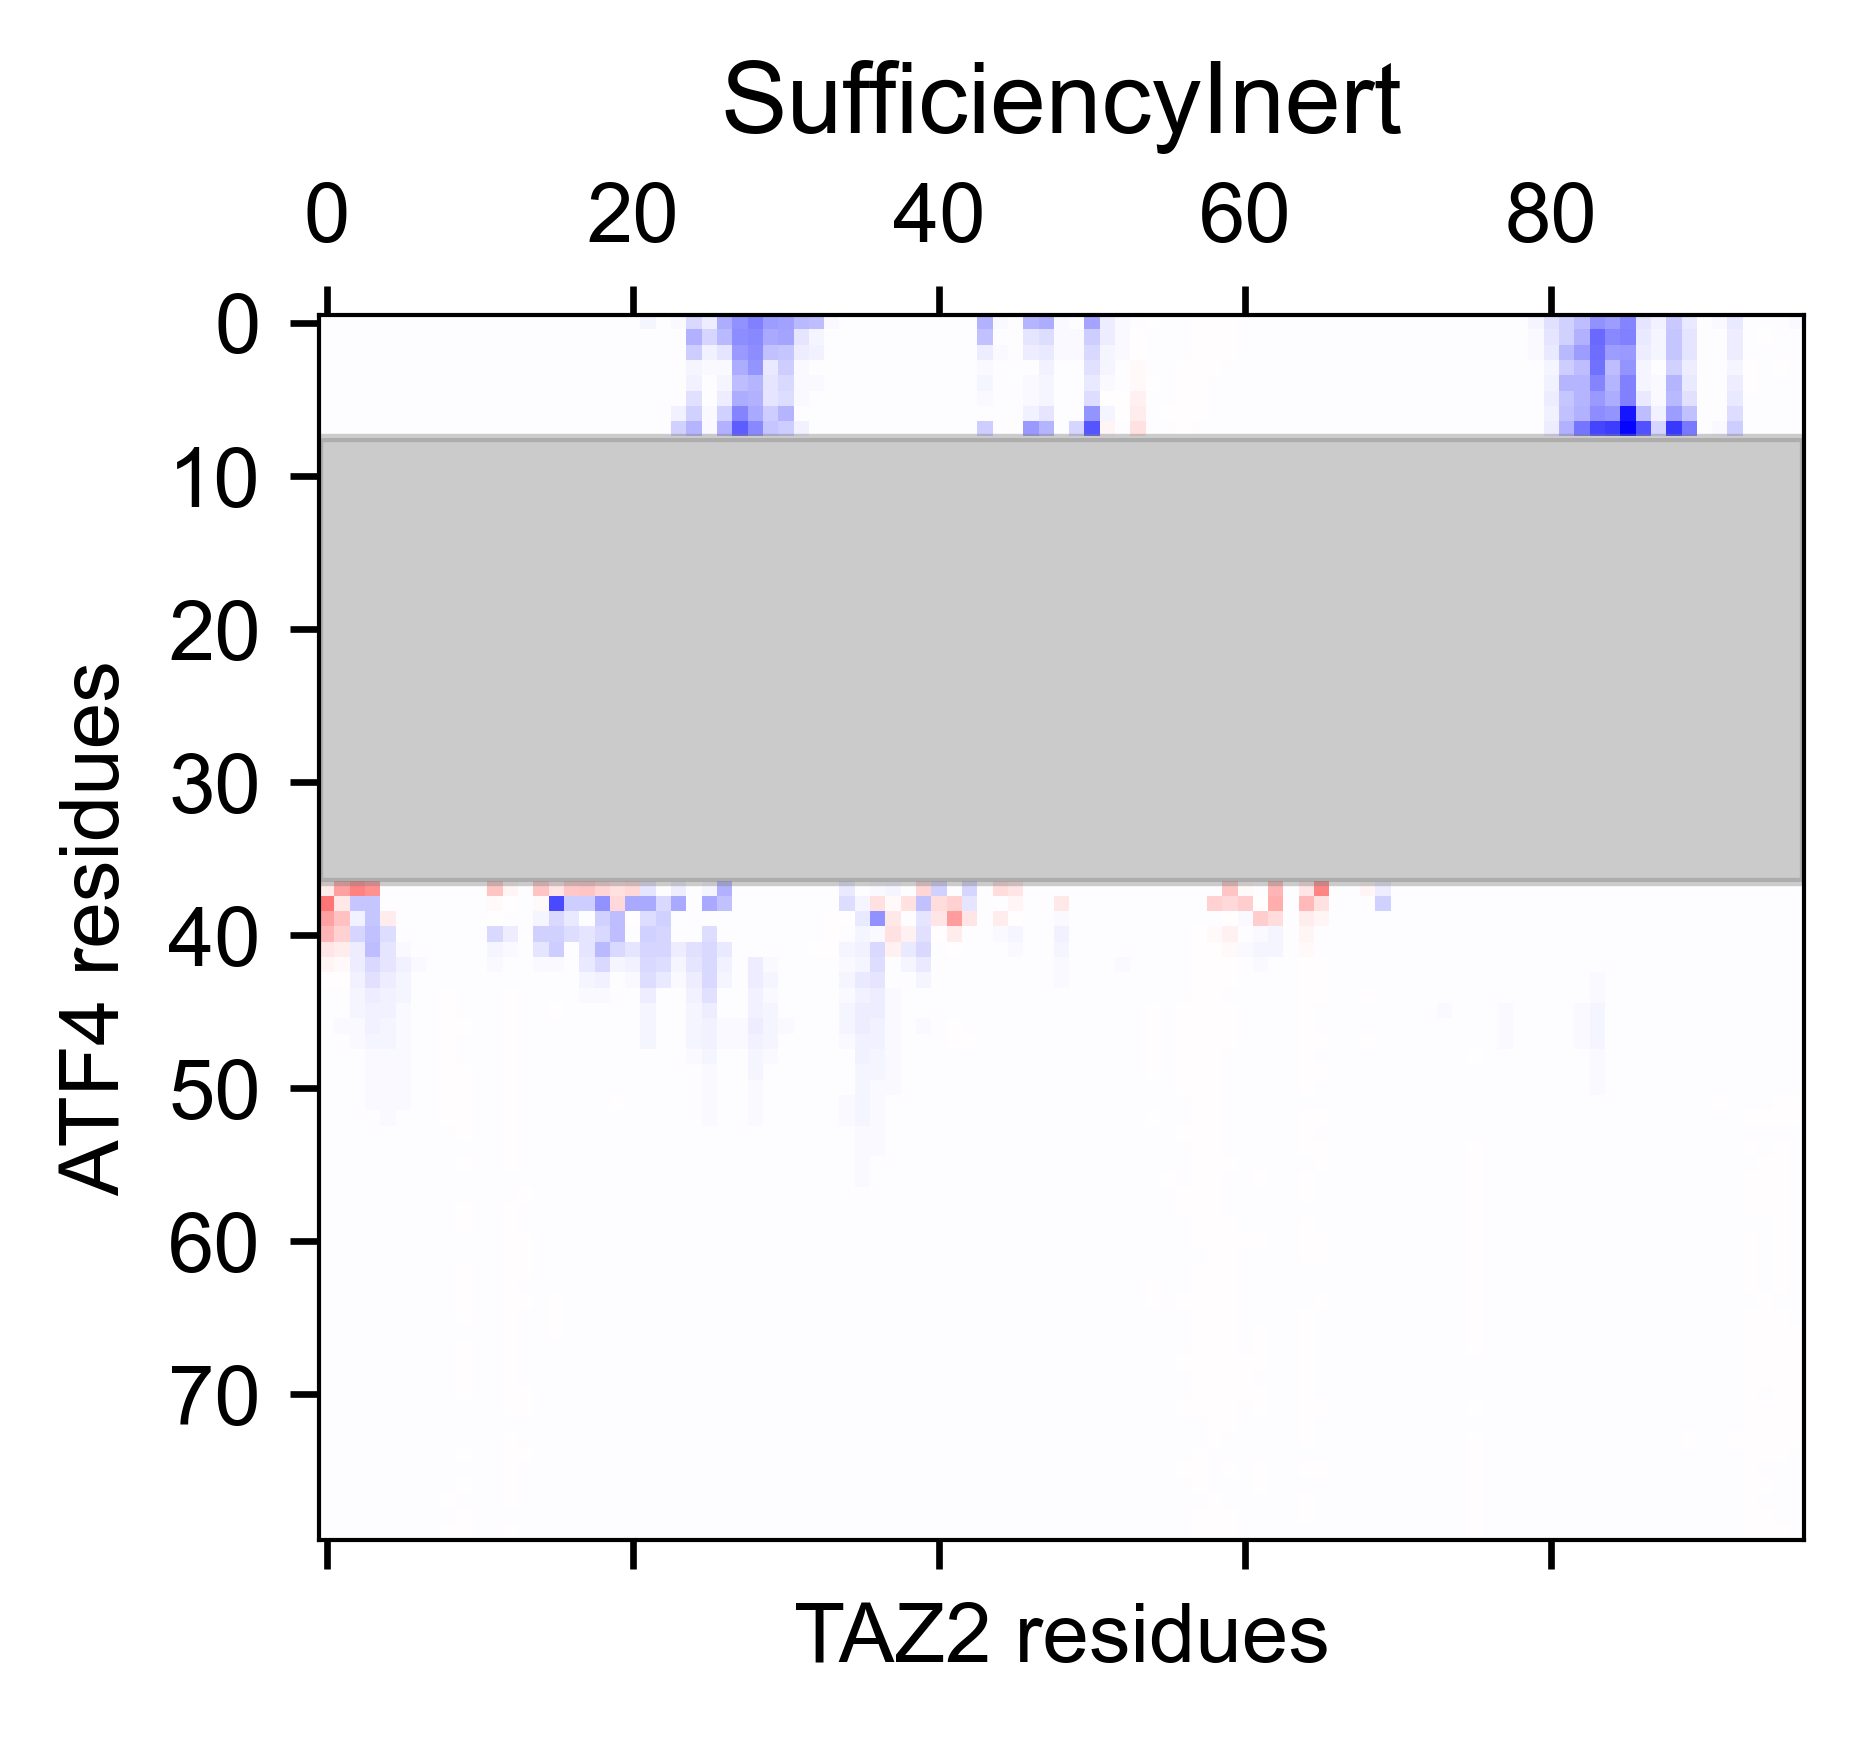

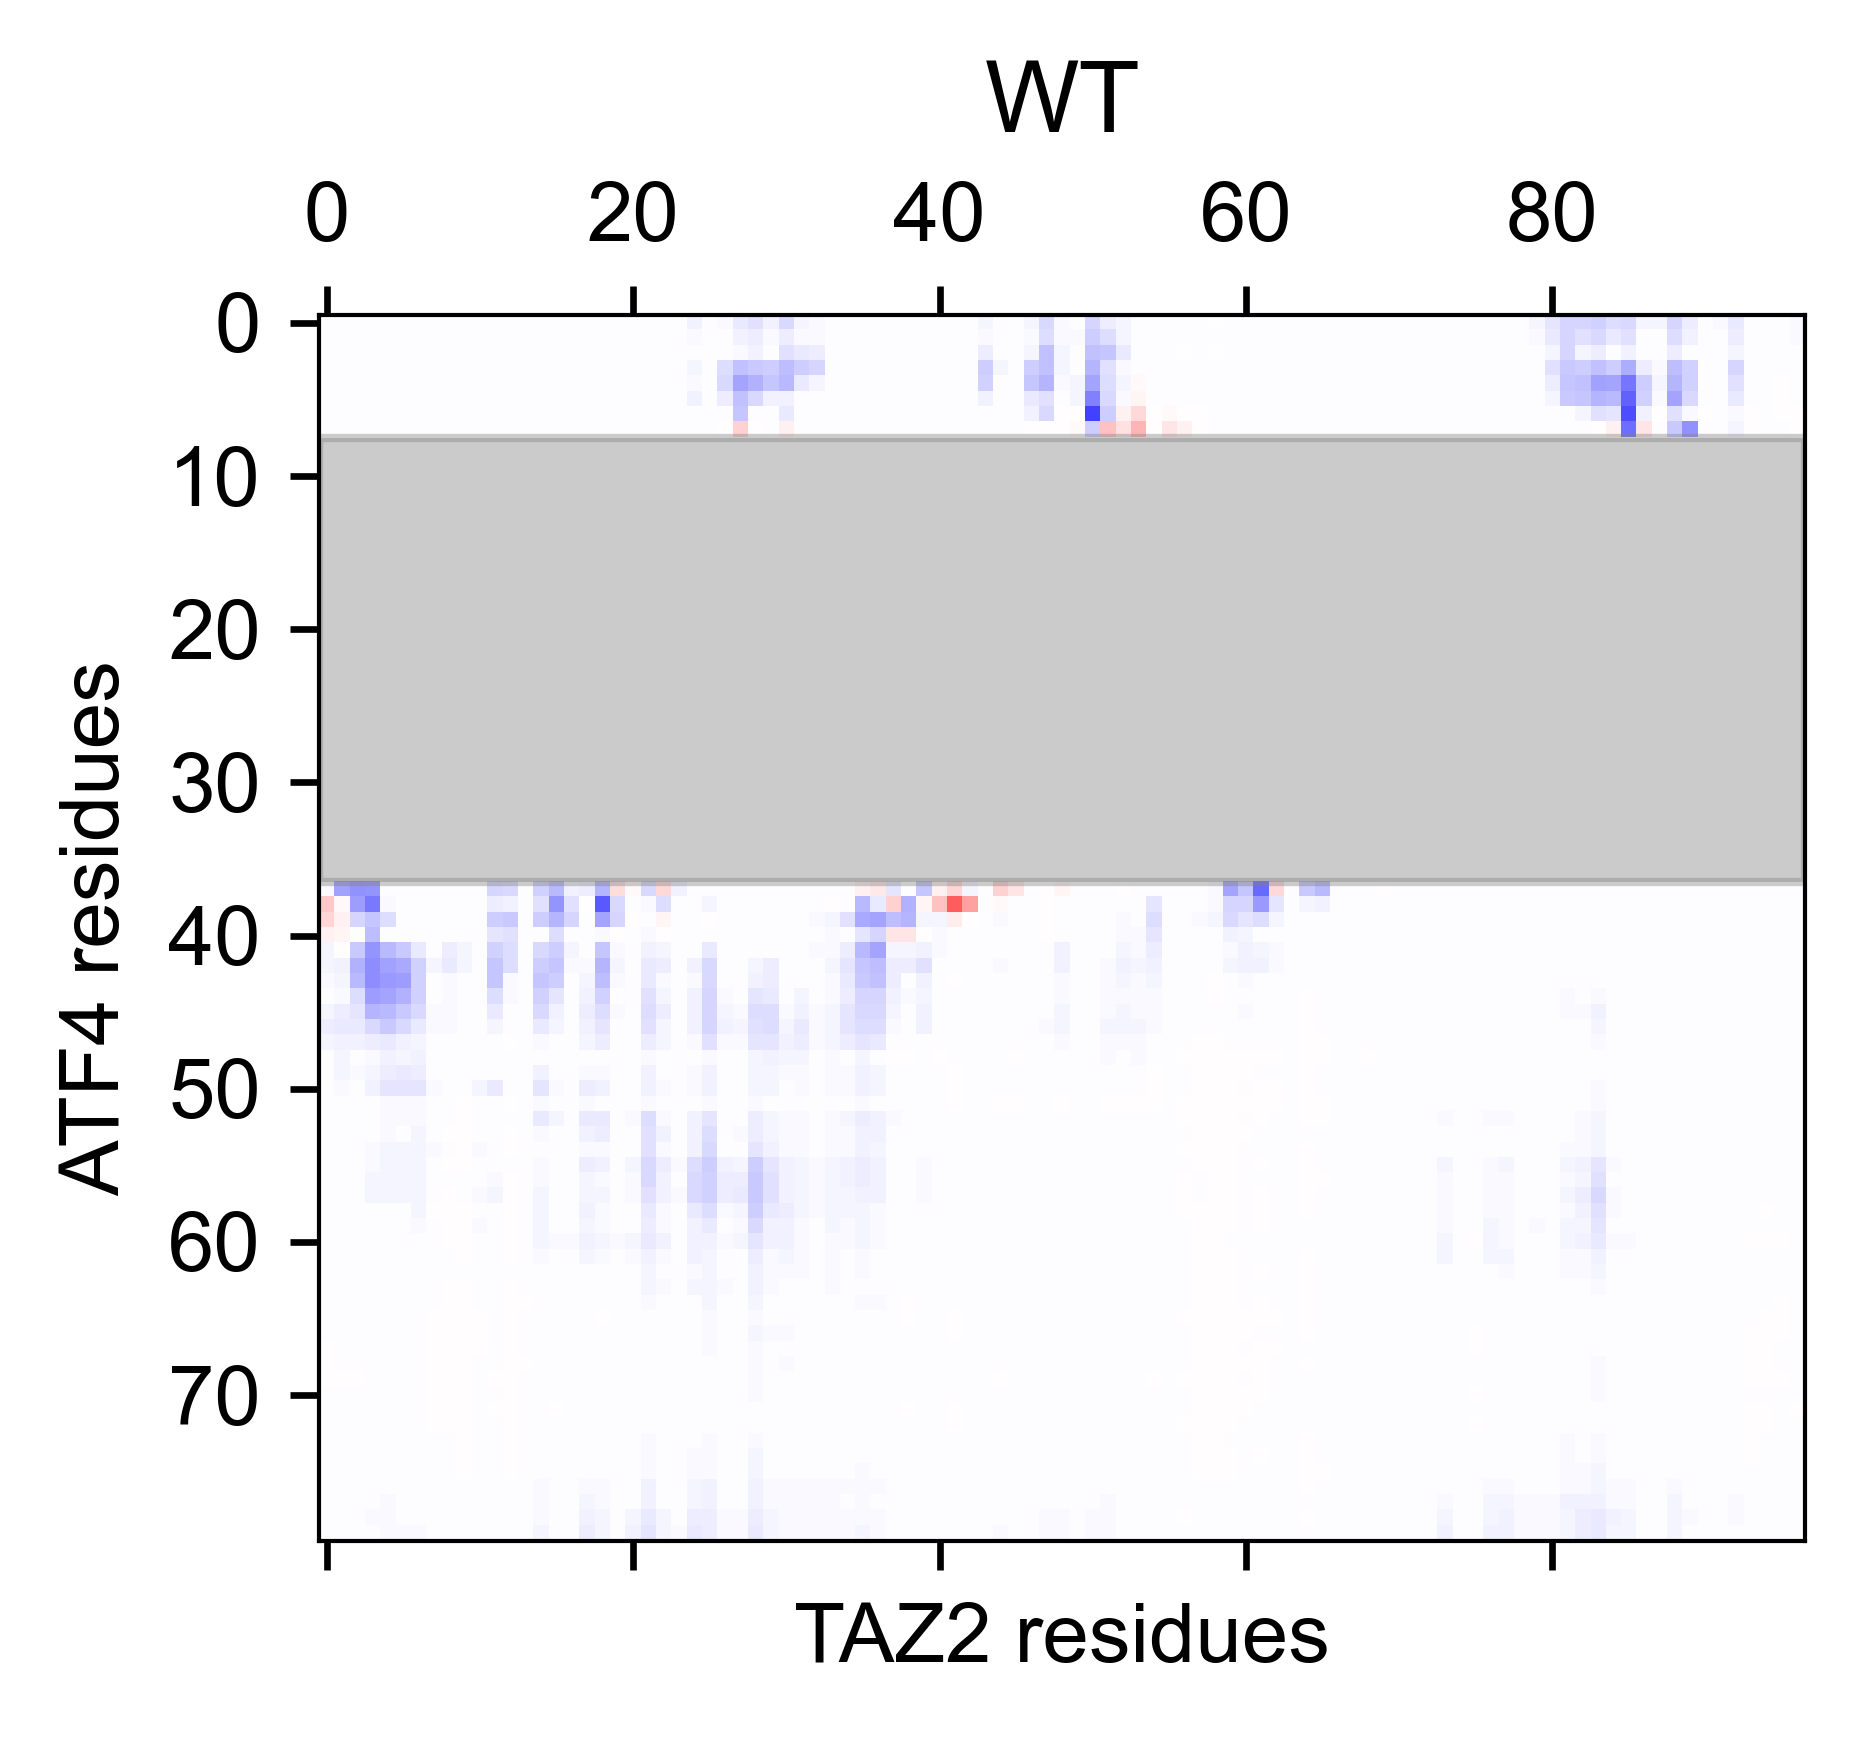

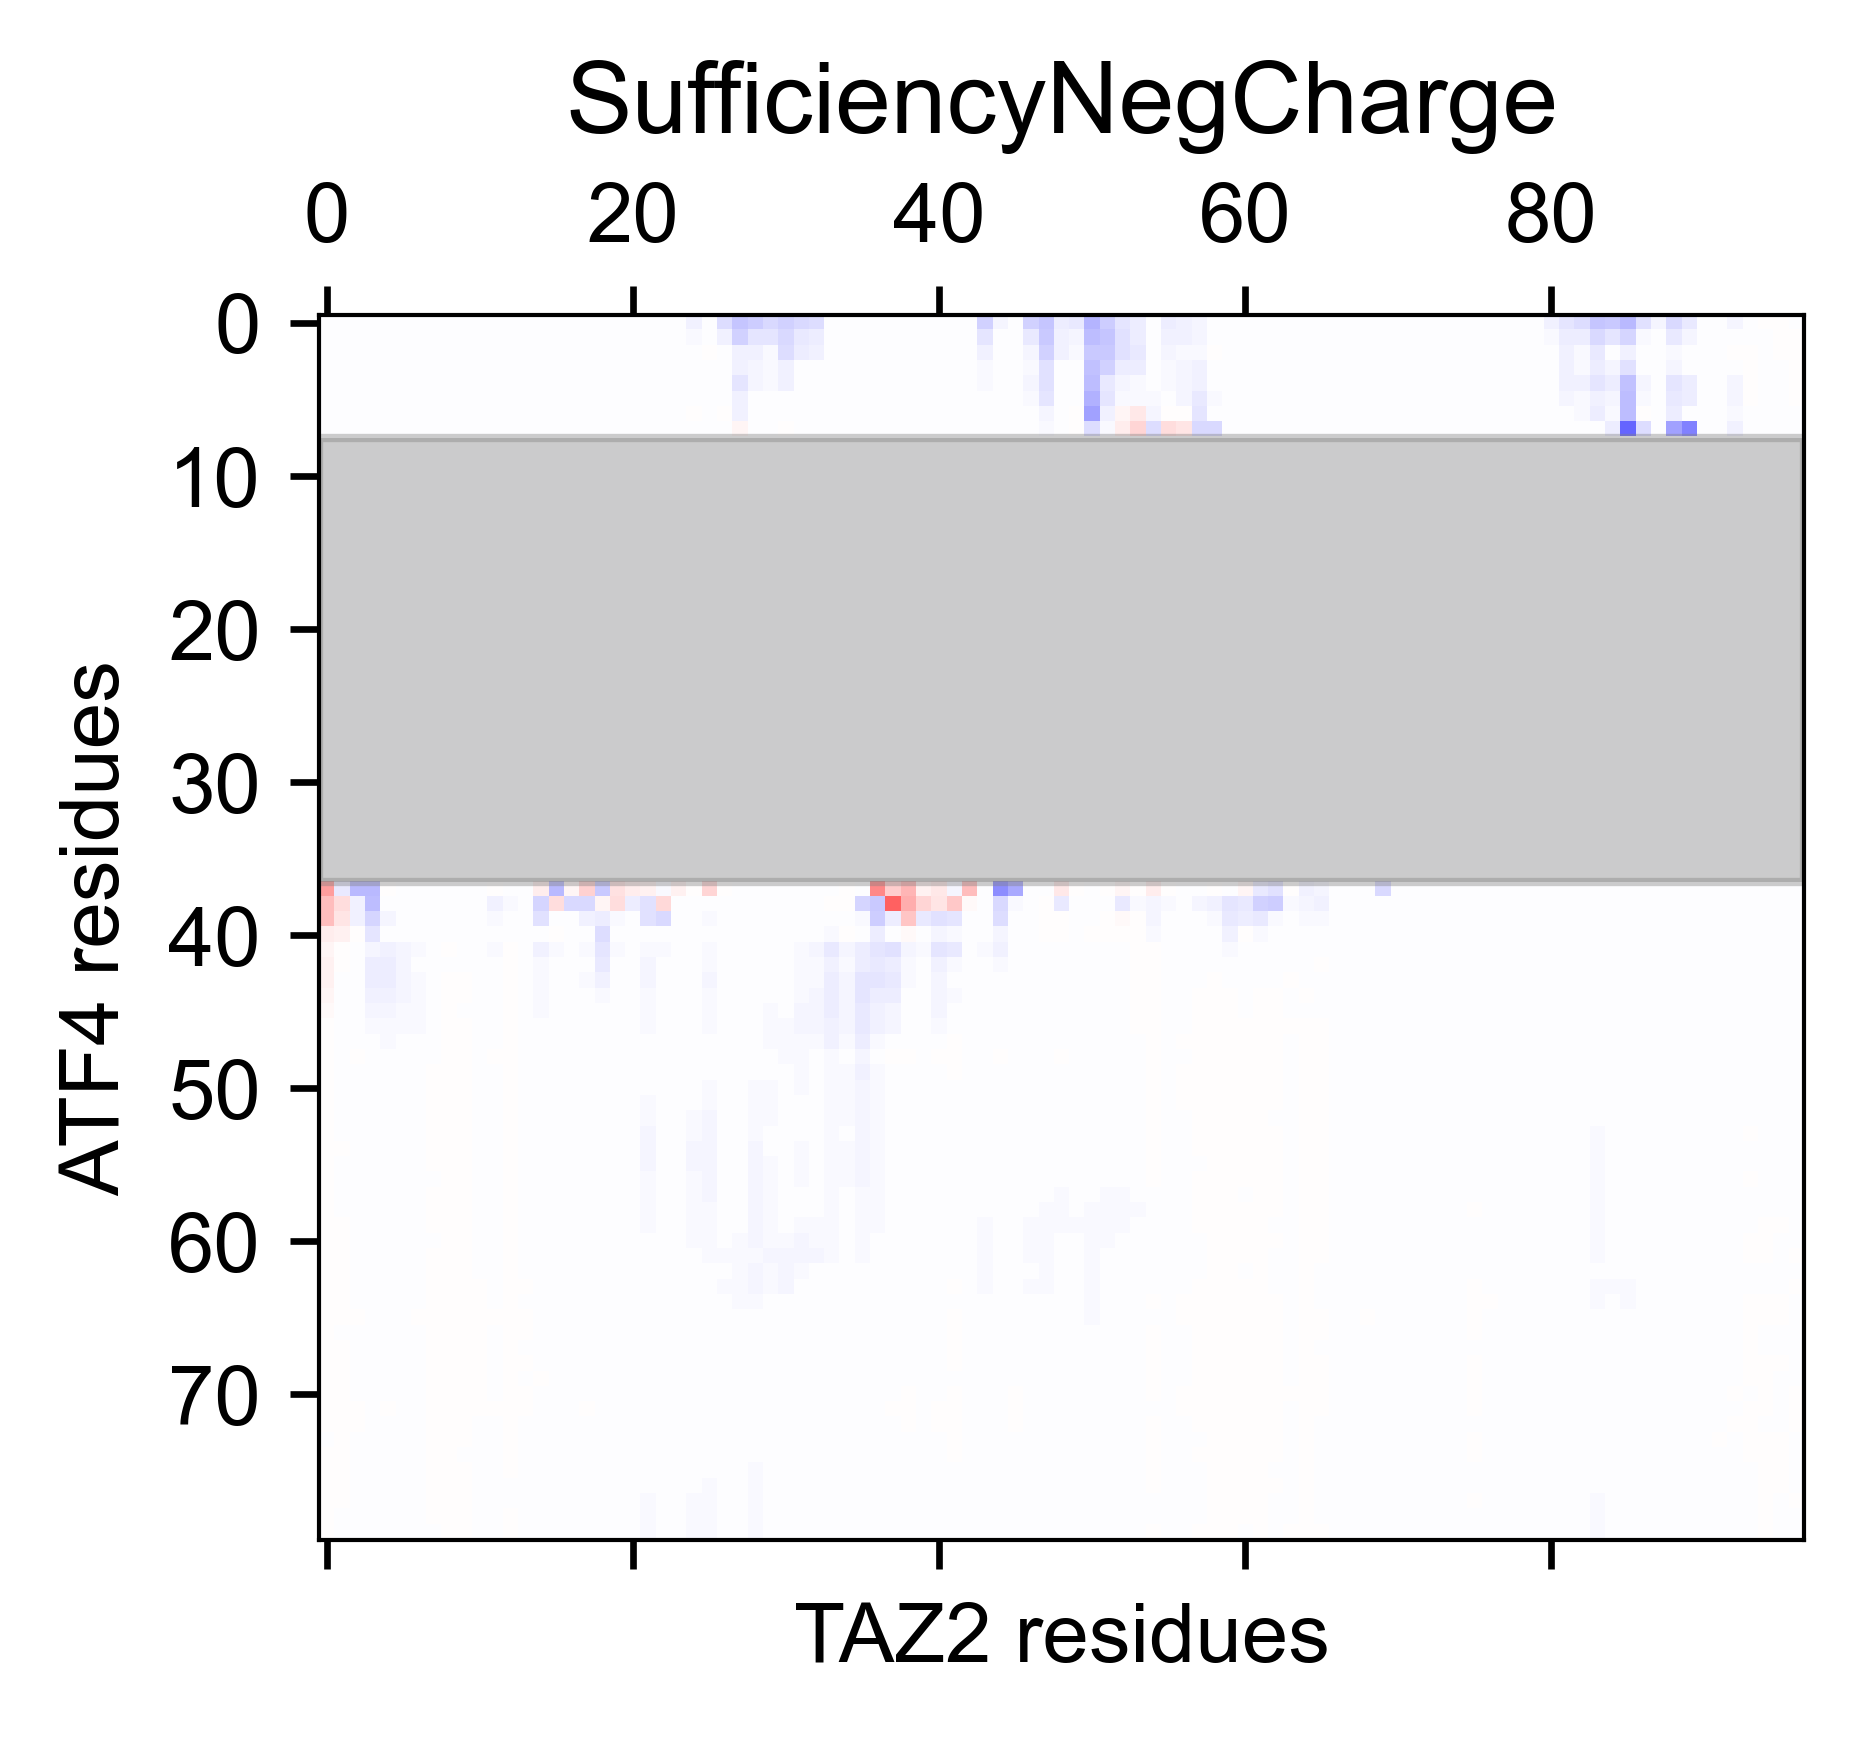

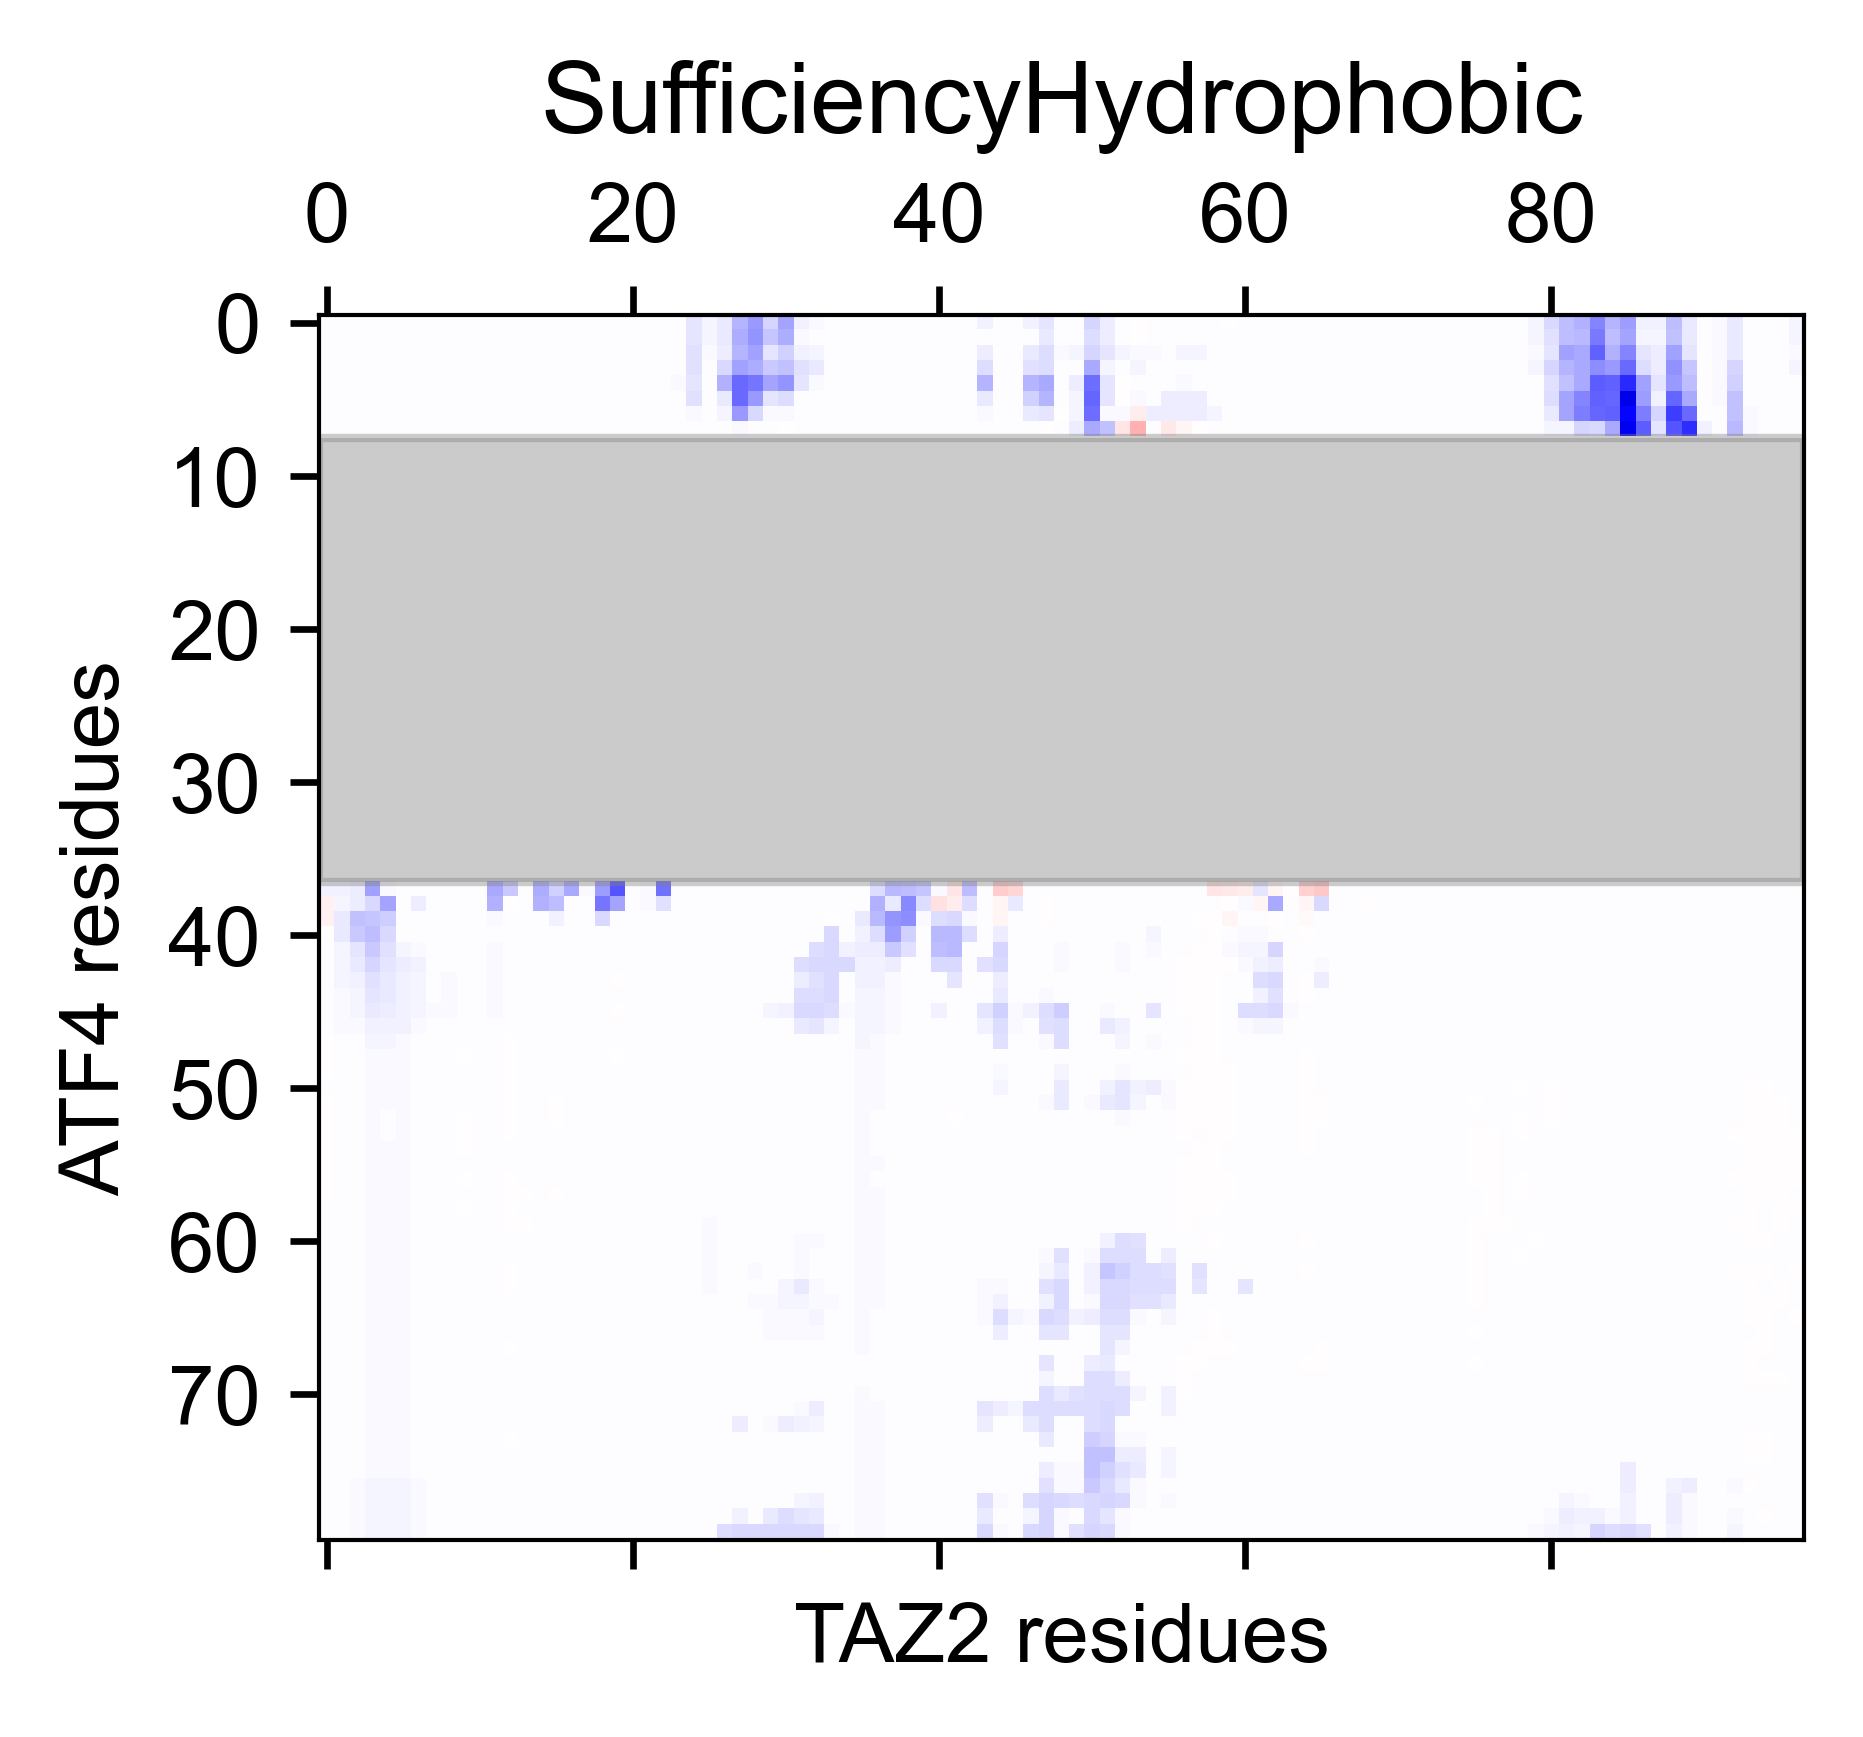

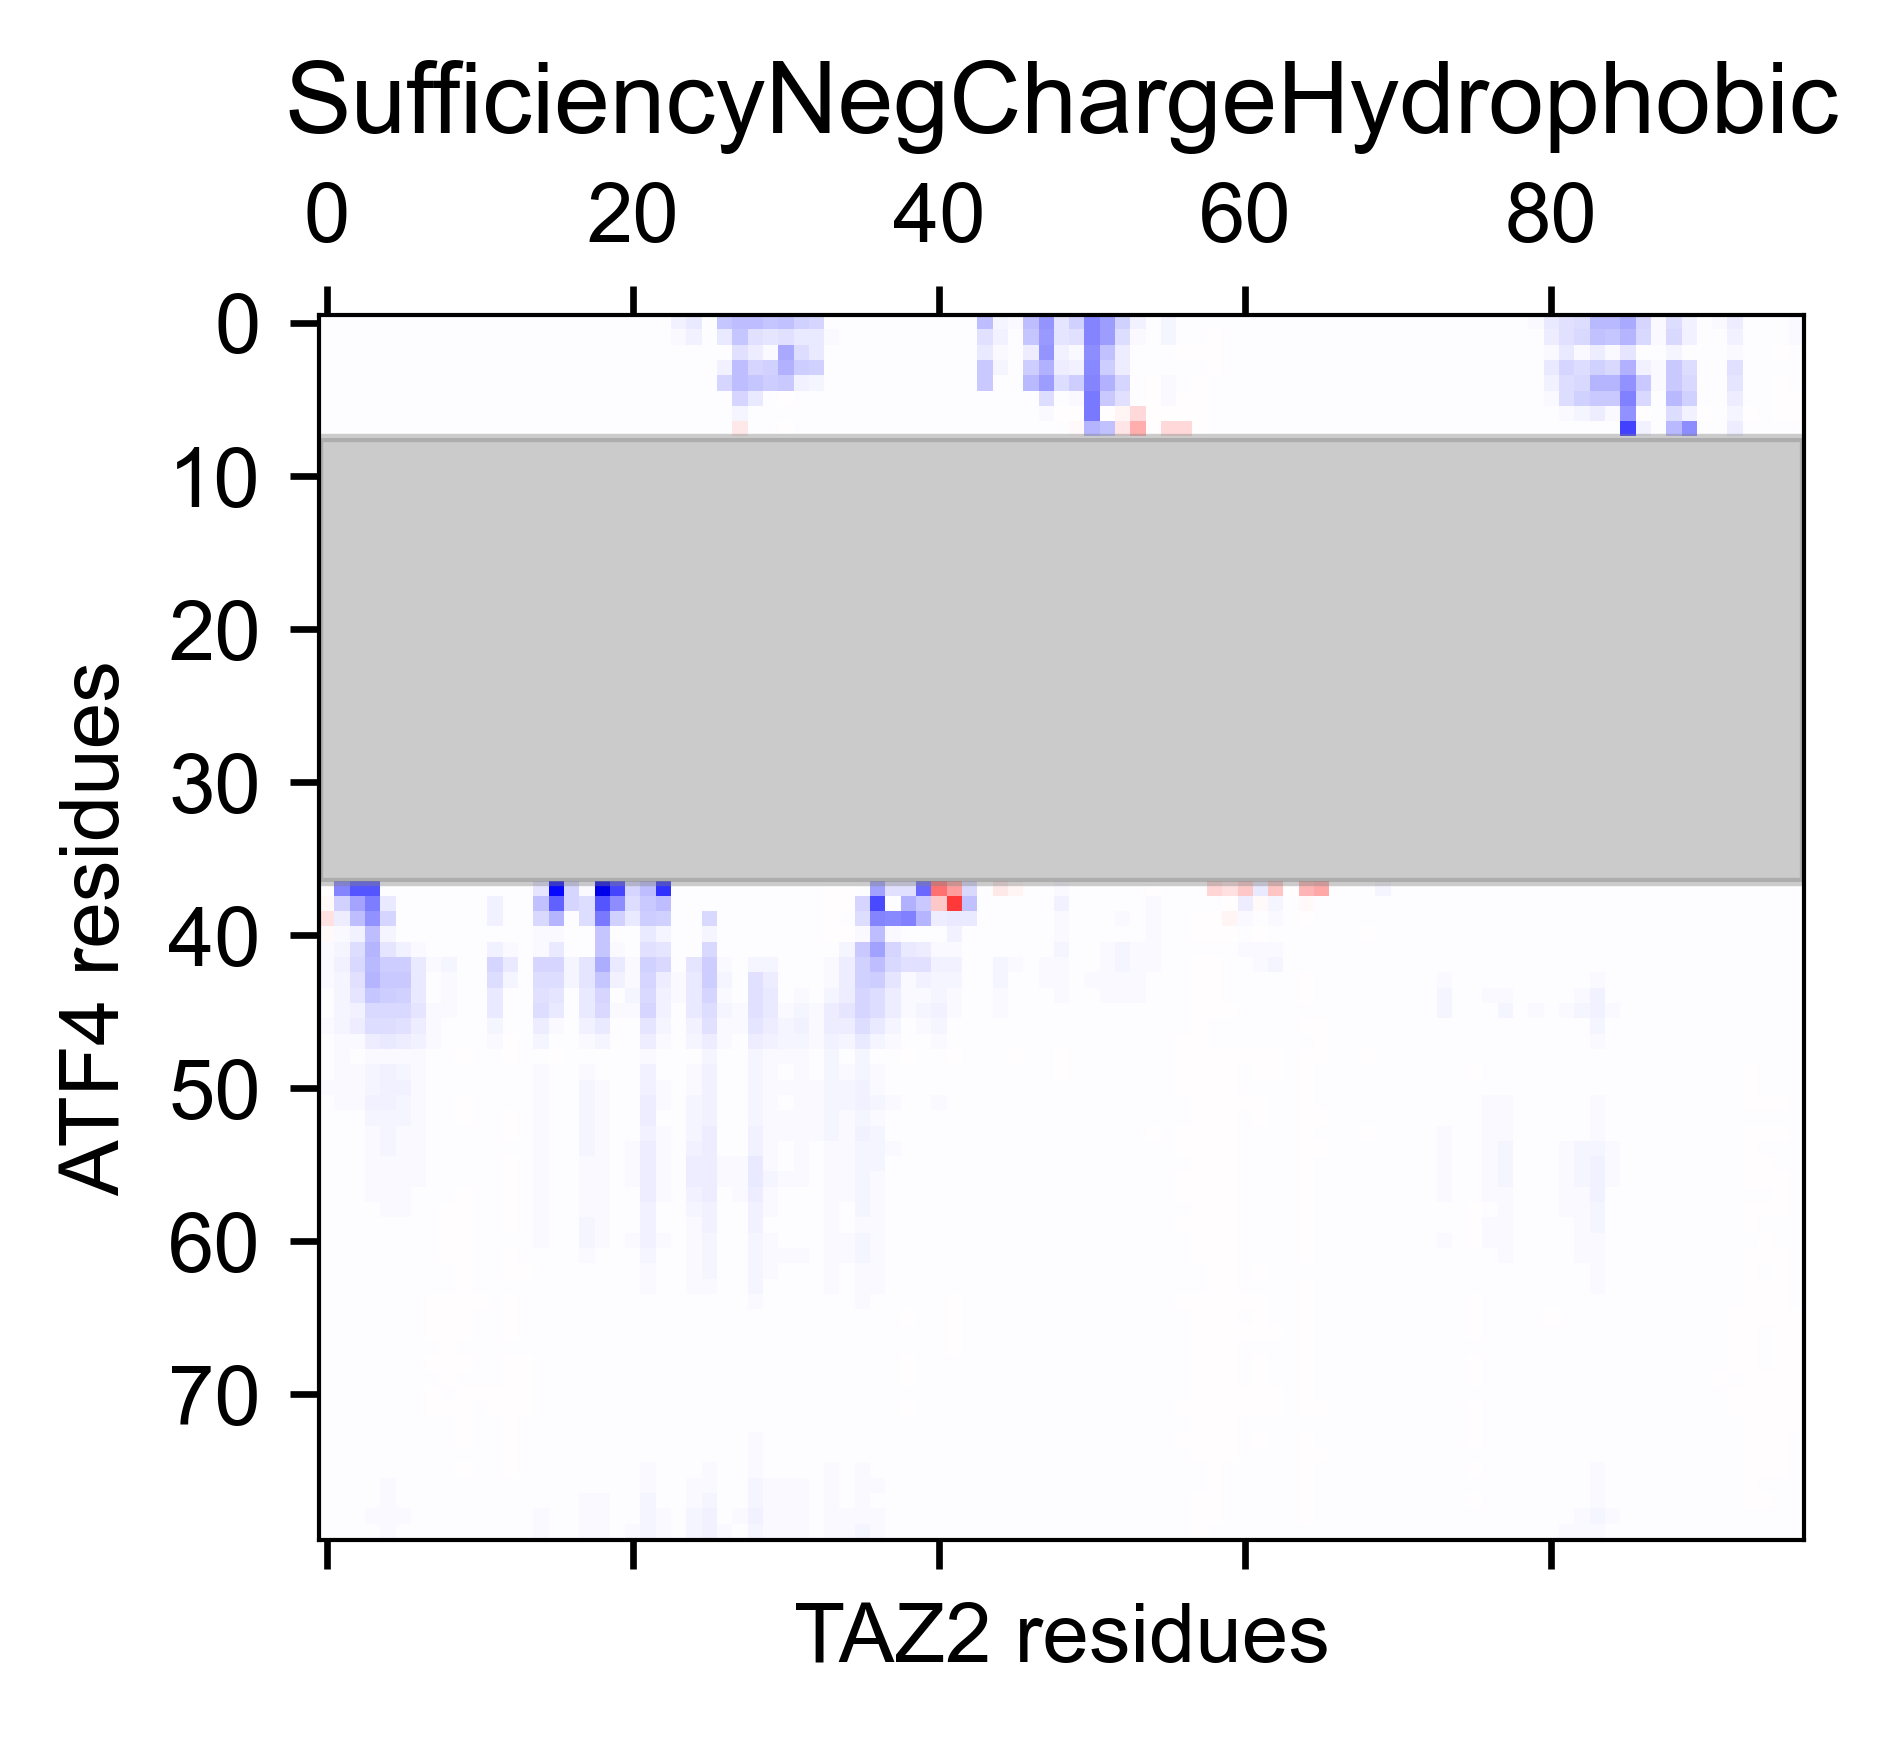

In [56]:
for construct in merged_norm_cmaps:
    temp_cmap = merged_norm_cmaps[construct].copy()
    temp_cmap[atf4_idr_residue_idxs[0]:atf4_idr_residue_idxs[1], :] = 0
    fig, ax = plt.subplots(figsize=(4,3), dpi=300)
    ax.matshow(temp_cmap, cmap='seismic_r', vmin=-1, vmax=1)
    ax.fill_between([-0.5,96.5], [atf4_idr_residue_idxs[0]-0.5, atf4_idr_residue_idxs[0]-0.5],
                   [atf4_idr_residue_idxs[1]-0.5, atf4_idr_residue_idxs[1]-0.5], color='gray', alpha=0.4)
    ax.set_title(construct)
    ax.set_ylabel('ATF4 residues')
    ax.set_xlabel('TAZ2 residues')
    plt.tight_layout()
    plt.savefig(f'/home/degriffith/projects/TADs/bound_sims/flanking_contacts/p300_coactivators_analyses/figures/sufficiency_heatmaps/{construct}_norm_heatmap.png')

In [43]:
atf4_idr_residue_idxs

[8, 37]

## Get heatmaps for manuscript

In [20]:
from matplotlib.backends.backend_pdf import PdfPages

In [12]:
#ms_cmaps = {'WT':{}, 'SufficiencyInert':{}, 'EV':{}}
ms_cmaps = {}

redo_root = '/work/degriffith/TADs/fixed_TAD_sims/p300_coactivators/flanking_idr_sims/sims/sept2023_sims'
round1_root = '/work/degriffith/TADs/fixed_TAD_sims/p300_coactivators/flanking_idr_sims/sims/round1_IDR_variants_TAZ2_WT'

sufficiency_name = 'Sufficiency_Inert_ExtendedMotif_ATF4'

psw_path = f"{round1_root}/structure_1/WT_ATF4_TAZ2_WT/coil_start/1/PSWFILE.psw"
psw_data = read_psw(psw_path)
fixed_residue_idxs = get_fixed_idr_residues(psw_data)
atf4_idr_residue_idxs = [fixed_residue_idxs[0]-3, fixed_residue_idxs[1]+2]

ATF4_EV_paths = [f'{round1_root}/structure_1/ev/WT_ATF4_TAZ2_WT/coil_start/1', f'{round1_root}/structure_1/ev2/WT_ATF4_TAZ2_WT/coil_start/1',
                 f'{round1_root}/structure_1/ev2/WT_ATF4_TAZ2_WT/coil_start/2', f'{round1_root}/structure_2/ev/WT_ATF4_TAZ2_WT/coil_start/1',
                 f'{round1_root}/structure_2/ev2/WT_ATF4_TAZ2_WT/coil_start/1', f'{round1_root}/structure_2/ev2/WT_ATF4_TAZ2_WT/coil_start/2',
                 f'{round1_root}/structure_3/ev/WT_ATF4_TAZ2_WT/coil_start/1', f'{round1_root}/structure_3/ev2/WT_ATF4_TAZ2_WT/coil_start/1',
                 f'{round1_root}/structure_3/ev2/WT_ATF4_TAZ2_WT/coil_start/2']

WT_paths = [f'{round1_root}/structure_1/WT_ATF4_TAZ2_WT/coil_start/1', f'{round1_root}/structure_1/WT_ATF4_TAZ2_WT/coil_start/2',
            f'{round1_root}/structure_1/WT_ATF4_TAZ2_WT/coil_start/3', f'{round1_root}/structure_1/WT_ATF4_TAZ2_WT/coil_start/4',
            f'{round1_root}/structure_2/WT_ATF4_TAZ2_WT/coil_start/1', f'{round1_root}/structure_2/WT_ATF4_TAZ2_WT/coil_start/2',
            f'{round1_root}/structure_2/WT_ATF4_TAZ2_WT/coil_start/3', f'{round1_root}/structure_2/WT_ATF4_TAZ2_WT/coil_start/4',
            f'{round1_root}/structure_3/WT_ATF4_TAZ2_WT/coil_start/1', f'{round1_root}/structure_3/WT_ATF4_TAZ2_WT/coil_start/2',
            f'{round1_root}/structure_3/WT_ATF4_TAZ2_WT/coil_start/3', f'{round1_root}/structure_3/WT_ATF4_TAZ2_WT/coil_start/4']

sufficiency_paths = [f'{redo_root}/{sufficiency_name}_1_TAZ2/coil_start/1', f'{redo_root}/{sufficiency_name}_1_TAZ2/coil_start/2',
                     f'{redo_root}/{sufficiency_name}_1_TAZ2/coil_start/3', f'{redo_root}/{sufficiency_name}_1_TAZ2/coil_start/4',
                     f'{redo_root}/{sufficiency_name}_2_TAZ2/coil_start/1', f'{redo_root}/{sufficiency_name}_2_TAZ2/coil_start/2',
                     f'{redo_root}/{sufficiency_name}_2_TAZ2/coil_start/3', f'{redo_root}/{sufficiency_name}_2_TAZ2/coil_start/4',
                     f'{redo_root}/{sufficiency_name}_3_TAZ2/coil_start/1', f'{redo_root}/{sufficiency_name}_3_TAZ2/coil_start/2',
                     f'{redo_root}/{sufficiency_name}_3_TAZ2/coil_start/3', f'{redo_root}/{sufficiency_name}_3_TAZ2/coil_start/4']

print('On WT')
ms_cmaps['WT'] = compute_mean_contact_map(WT_paths)

print('On EV')
ms_cmaps['EV'] = compute_mean_contact_map(ATF4_EV_paths)

print('On Sufficiency')
ms_cmaps['SufficiencyInert'] = compute_mean_contact_map(sufficiency_paths)

Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading protein trajectory...
Creating distance map...
Loading pr

In [36]:
# Plotting functions
def plot_contact_heatmap_pdf(cmap, fixed_idr_residues, outfile, title=None):
    fig = plt.figure(figsize=(3,3), dpi=500)
    ax = plt.gca()
    im = ax.imshow(cmap, cmap='afmhot_r', 
                   norm=colors.PowerNorm(gamma=0.2, vmin=0, vmax=1),
                   interpolation='none', rasterized=True)

    ax.hlines(fixed_idr_residues[0], 0, len(cmap[0]), color='black', linestyle='-', linewidth=0.1, rasterized=True)
    ax.hlines(fixed_idr_residues[1], 0, len(cmap[0]), color='black', linestyle='-', linewidth=0.1, rasterized=True)

    if title is None:
        ax.set_title('Contact frequency', fontweight='bold')
    else:
        ax.set_title(title, fontweight='bold')
    ax.set_xlabel('FD residues')
    ax.set_ylabel('IDR residues')
    ax.set_xlim(0,len(cmap[0]))

    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    cbar = plt.colorbar(im, cax=cax)
    tick_font_size = 6
    cbar.ax.tick_params(labelsize=5)

    for ax in fig.get_axes():    # <--- New line
        ax.set_rasterized(True)  # <--- New line   

    plt.tight_layout()
    
    # save out as pdf
    with PdfPages(outfile) as pdf:
        pdf.savefig(fig, dpi=500)  

    plt.show()

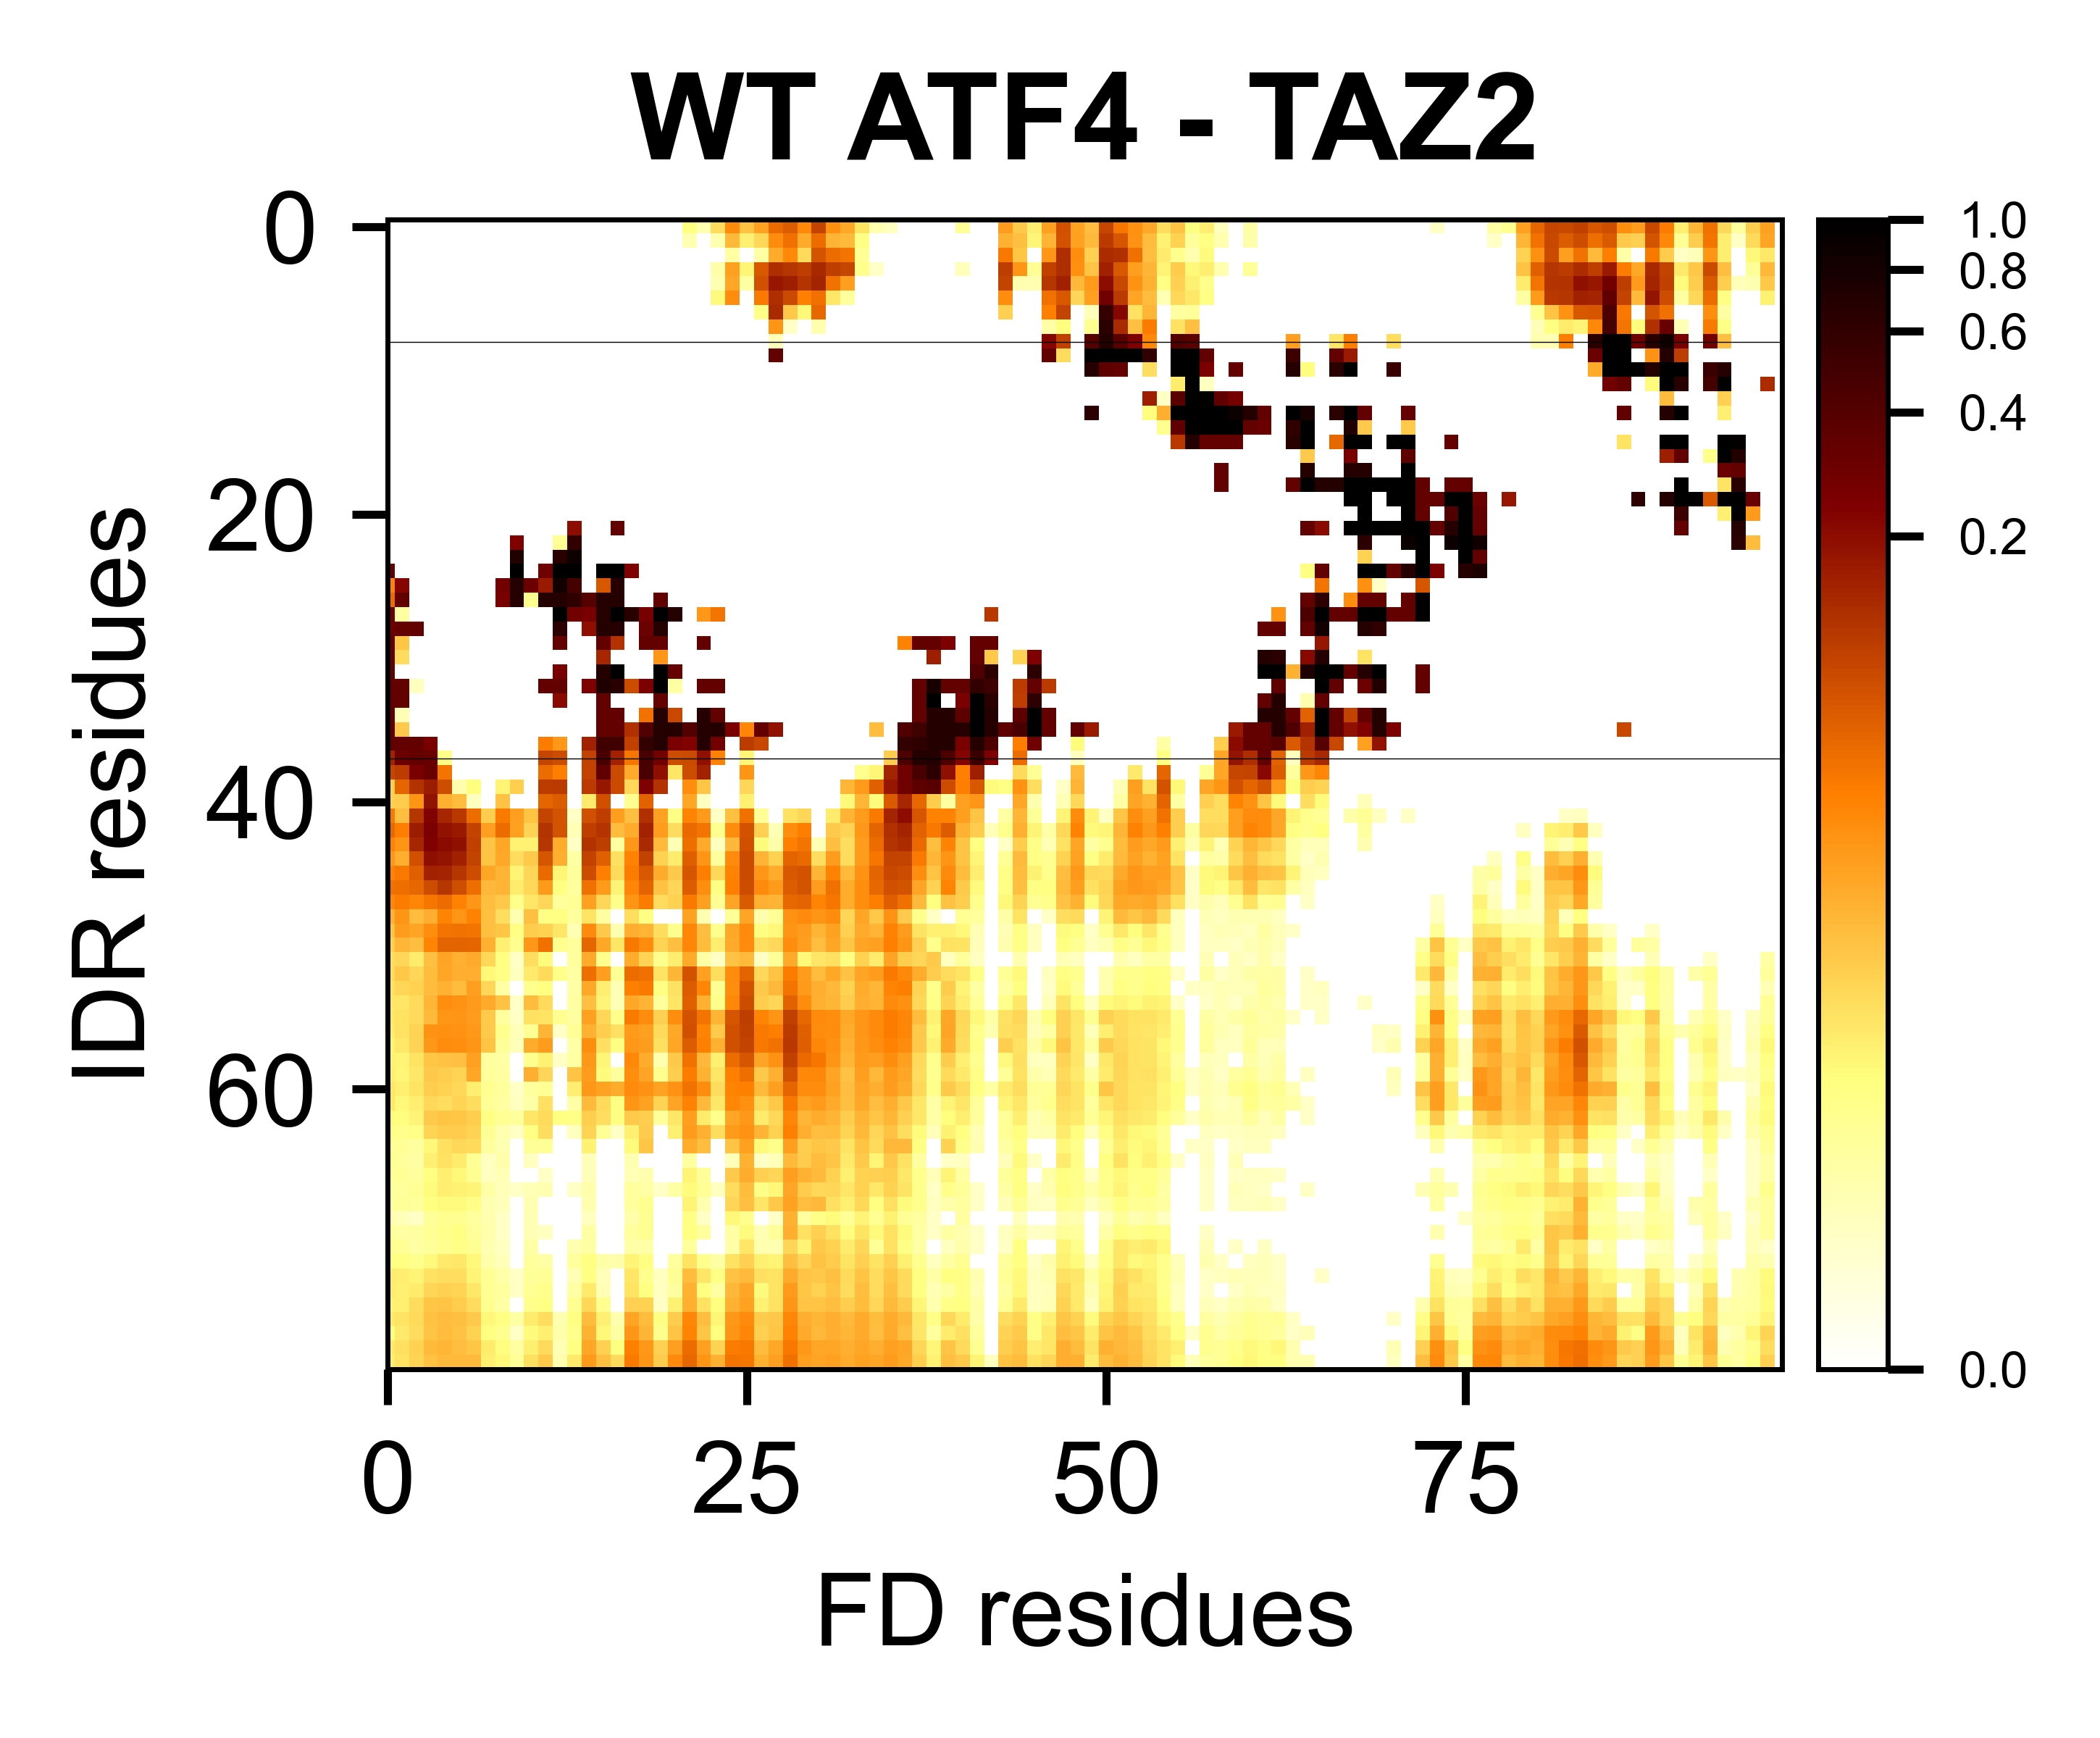

In [37]:
plot_contact_heatmap_pdf(ms_cmaps['WT'], atf4_idr_residue_idxs, 
                         '/home/degriffith/projects/TADs/manuscript/WT_ATF4_TAZ2_contact_heatmap.pdf', 
                         title='WT ATF4 - TAZ2')

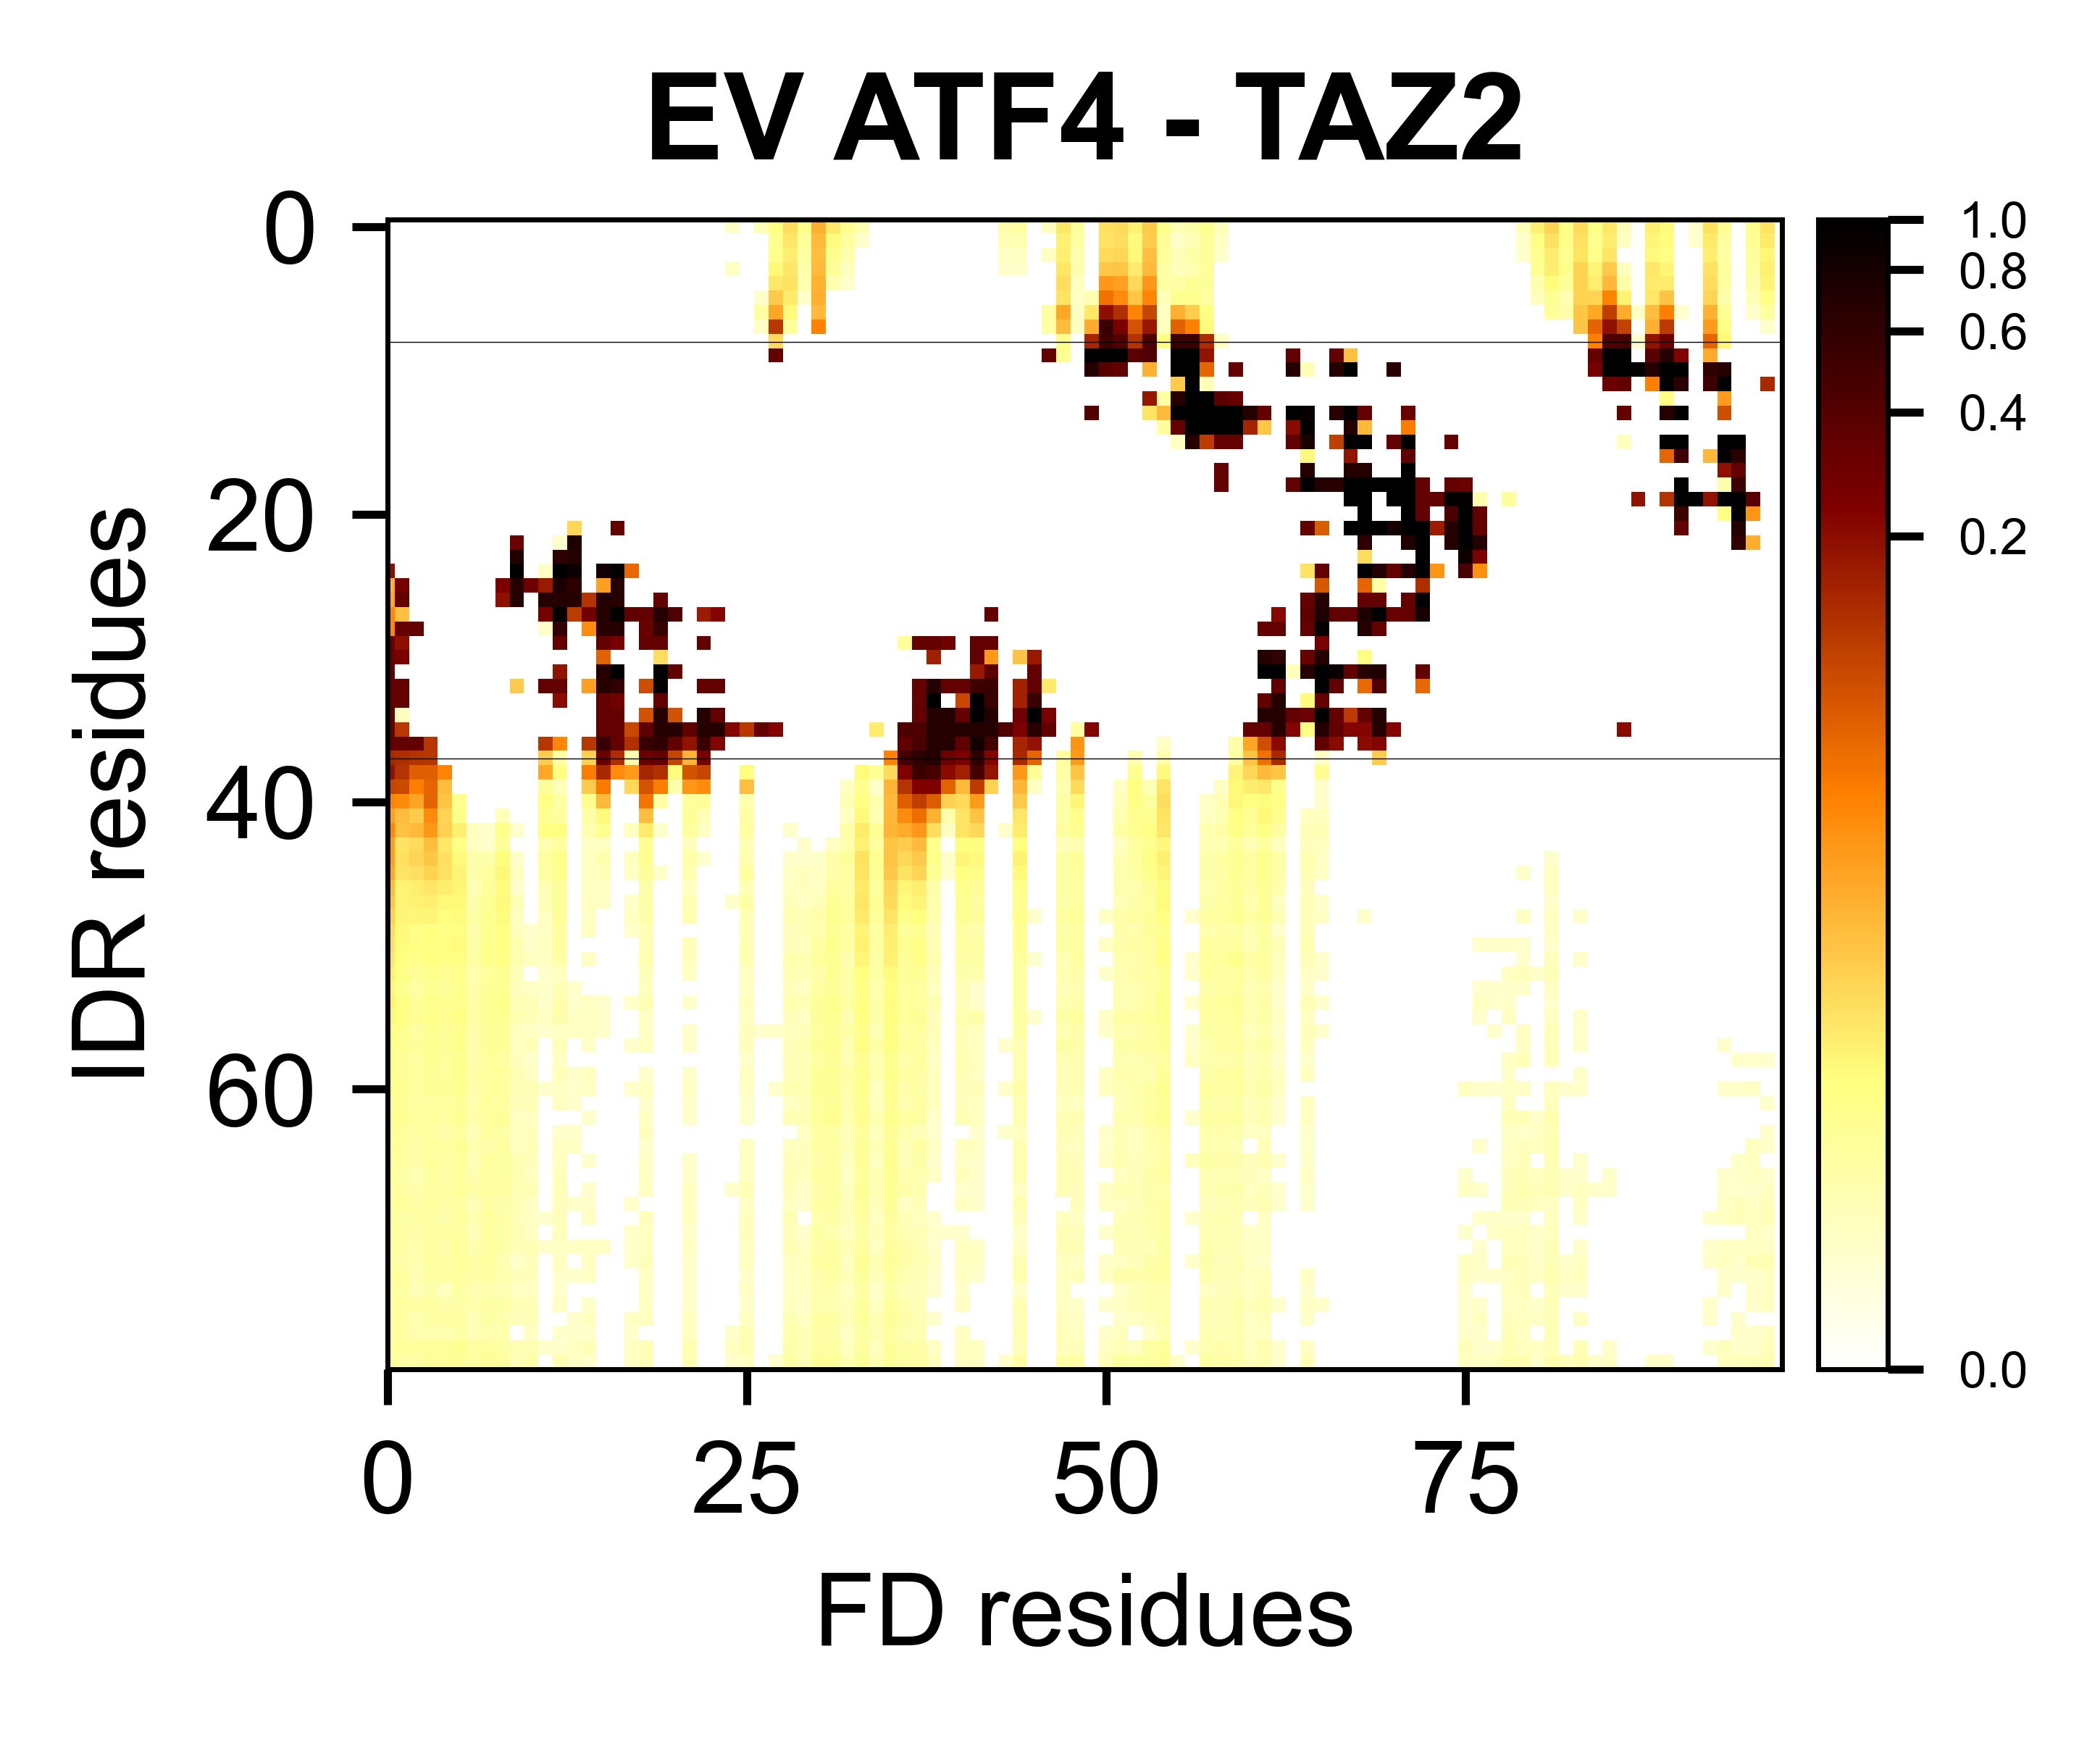

In [40]:
plot_contact_heatmap_pdf(ms_cmaps['EV'], atf4_idr_residue_idxs, 
                         '/home/degriffith/projects/TADs/manuscript/EV_ATF4_TAZ2_contact_heatmap.pdf', 
                         title='EV ATF4 - TAZ2')

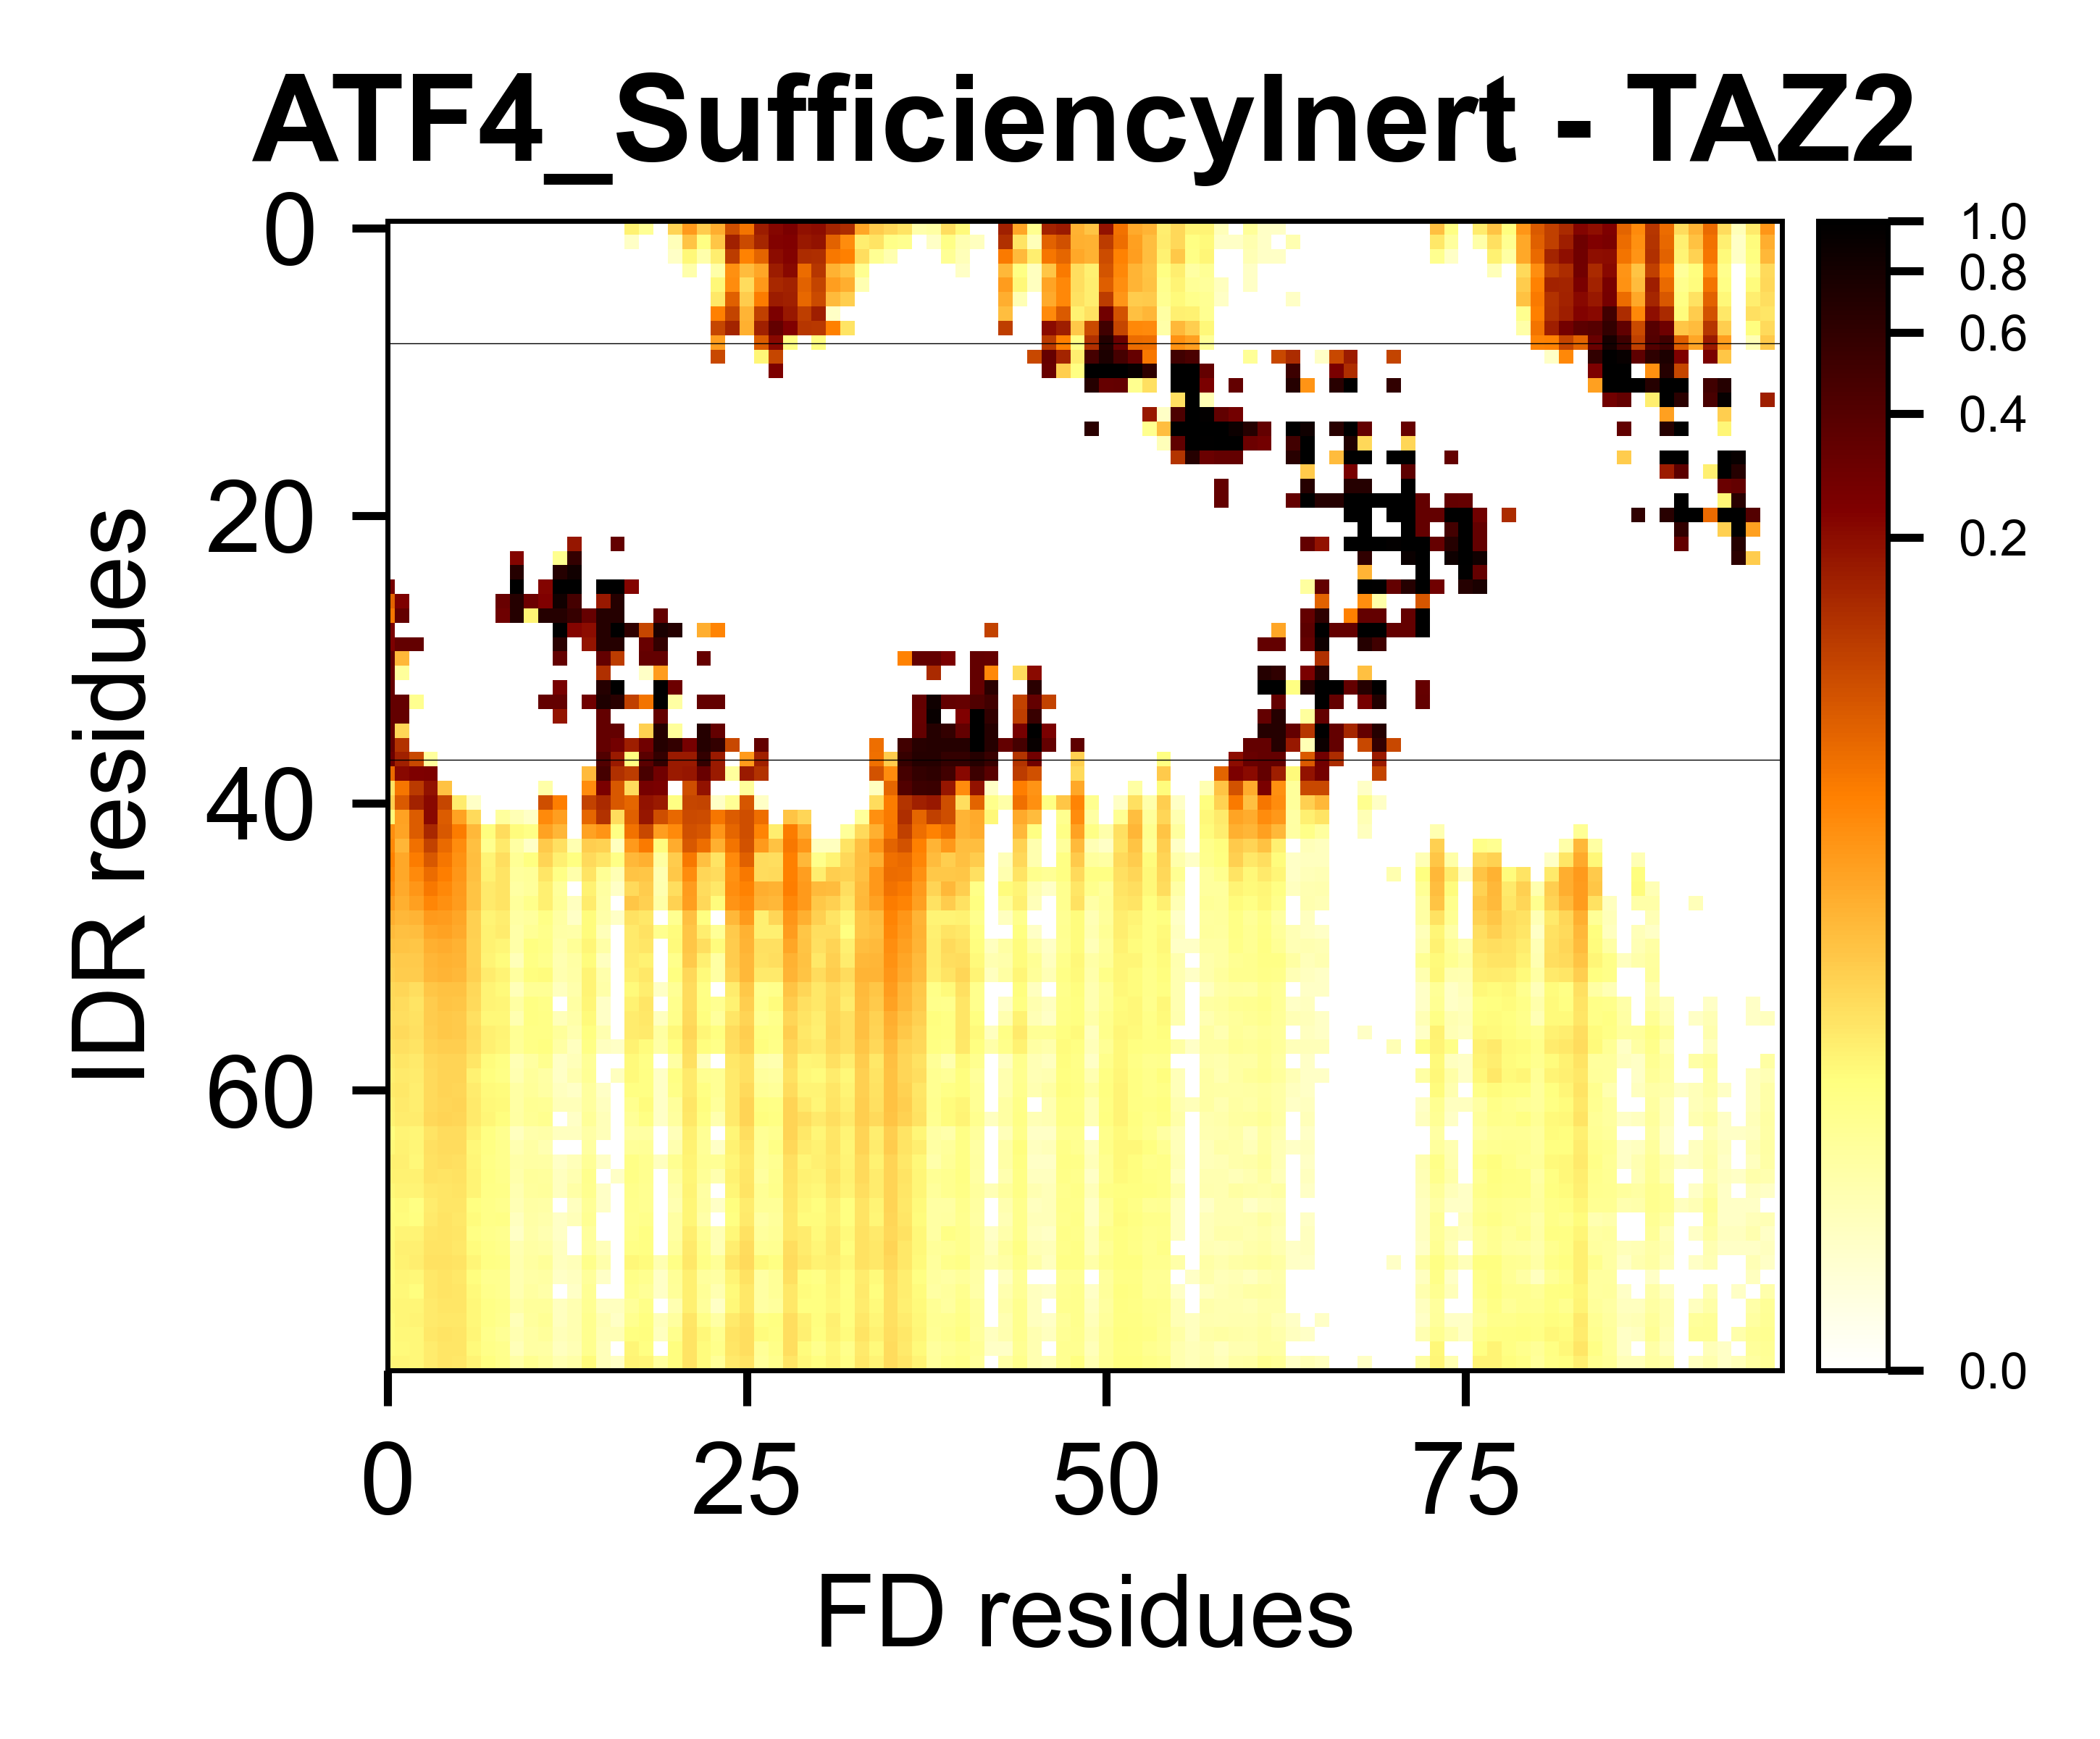

In [41]:
plot_contact_heatmap_pdf(ms_cmaps['SufficiencyInert'], atf4_idr_residue_idxs, 
                         '/home/degriffith/projects/TADs/manuscript/SufficiencyInert_ATF4_TAZ2_contact_heatmap.pdf', 
                         title='ATF4_SufficiencyInert - TAZ2')

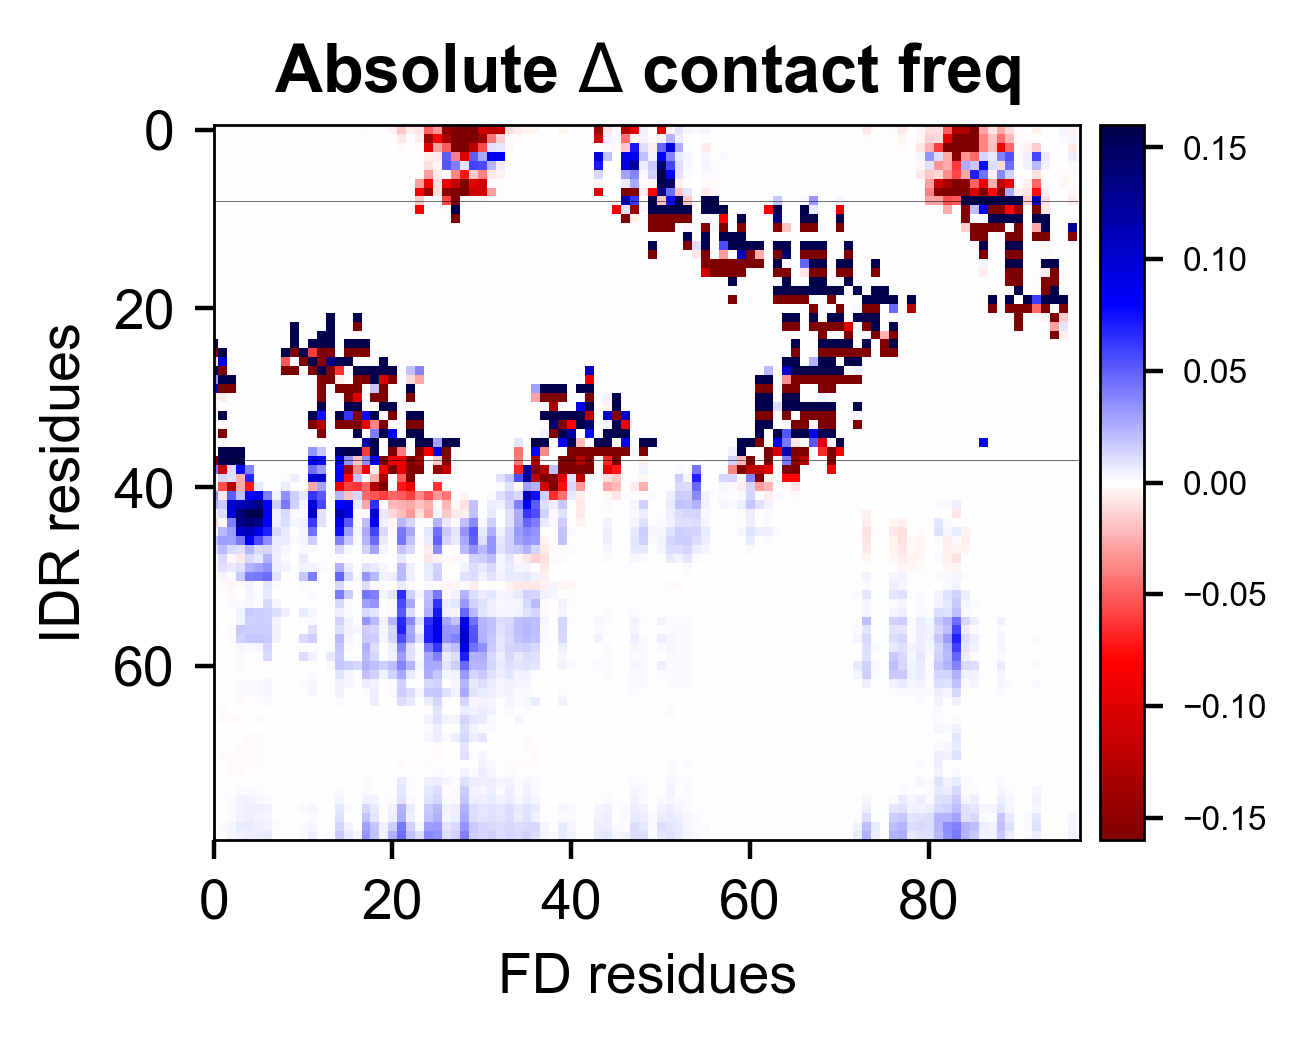

In [16]:
plot_ev_abs_comparison_heatmap(ms_cmaps['WT'] - ms_cmaps['SufficiencyInert'], atf4_idr_residue_idxs)

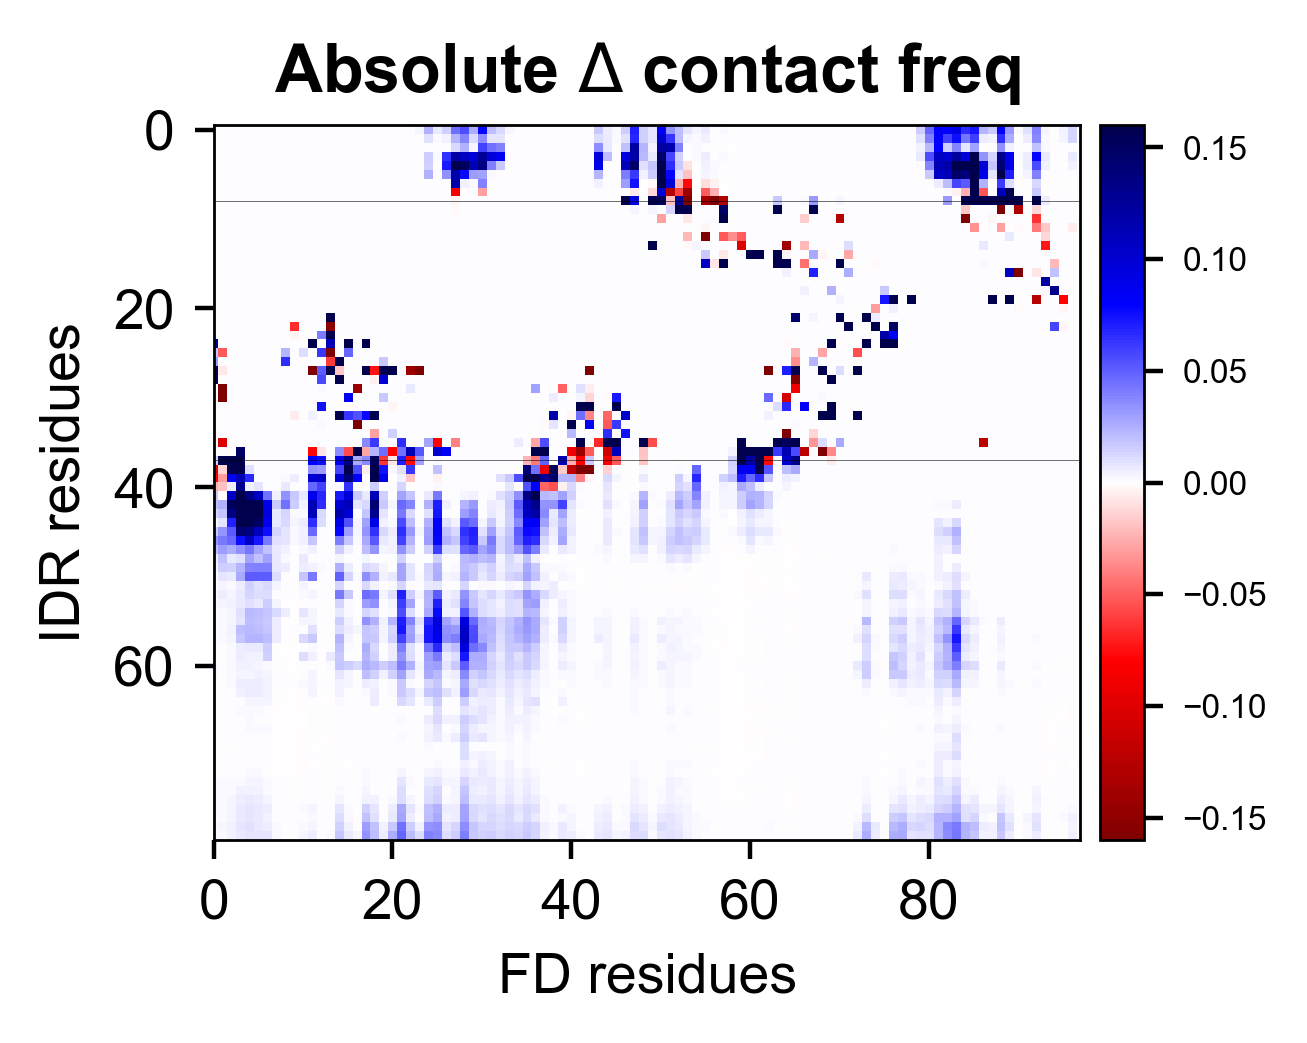

In [17]:
plot_ev_abs_comparison_heatmap(ms_cmaps['WT'] - ms_cmaps['EV'], atf4_idr_residue_idxs)

In [18]:
diff = ms_cmaps['WT'] - ms_cmaps['SufficiencyInert']

In [19]:
np.sum(diff)

10.006442314371053